In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import folium
import io
from PIL import Image
import os, time
# from selenium import webdriver
# import geocoder
from tqdm import tqdm
import geopandas as gpd
# import pygeos

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
# from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score

from pingouin import partial_corr
import pingouin as pg

from sklearn import preprocessing
import xgboost as xgb

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2053]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon, box

In [1027]:
dfOz = gpd.read_file('dataset_Australia_East_coast.geojson')

In [1028]:
dfOz = dfOz[dfOz['d50']<=2]
len(dfOz)

ind = np.where(dfOz['quality_flag']!='Low')[0]
len(ind)
dfOz = dfOz.iloc[ind]
len(dfOz)

272

In [1029]:
dfOz['mstr'] = dfOz['max_tide_obs'] - dfOz['min_tide_obs']
dfOz['code'] = np.zeros(len(dfOz))
dfOz = dfOz.dropna()
# df.head()
len(dfOz)

272

In [1030]:
dfOz.keys()

Index(['beach_id', 'beach_slope_average', 'width_ci_average', 'quality_flag',
       'mstr', 'hsig_median', 'prc_mstr_obs', 'min_tide_obs', 'max_tide_obs',
       'sl_points_average', 'beach_length', 'coastal_region',
       'primary_comp_id', 'secondary_comp_id', 'd50', 'distance_to_sample',
       'latitude', 'longitude', 'Hs_mean', 'Hs_max', 'Tp_mean', 'Wdir_mean',
       'Wdir_weighted_mean', 'geometry', 'code'],
      dtype='object')

In [1031]:
dfUS = pd.read_csv('ML_slope_wave_atlantic_2022-05-18_Data_Post2012_VerifiedOnshore_0.0015_right_transects.csv')

dfUS = dfUS[dfUS['d50']<=2]

dfUS['code'] = np.ones(len(dfUS))

len(dfUS)

5104

In [1032]:
dfUS.keys()

Index(['Unnamed: 0', 'hs_max', 'hs_mean', 'dir', 'tp', 'latitude_left',
       'latitude_left.1', 'longitude_left', 'longitude_left.1',
       'quality_flag_left', 'quality_flag_right', 'd50', 'width_ci_average',
       'beach_slope_average', 'beach_slope_median', 'sl_points_average',
       'mstr', 'prc_mstr_obs', 'min_tide_obs', 'max_tide_obs', 'site_id',
       'beach_slope', 'lower_conf_bound', 'upper_conf_bound', 'width_ci',
       'sl_points', 'trend', 'distance', 'latitude', 'longitude', 'code'],
      dtype='object')

In [1033]:
dfUS.rename(columns = {'hs_max':'Hs_max', 'hs_mean':'Hs_mean', 'tp':'Tp_mean', 'dir':'Wdir_mean'}, inplace = True)

In [1034]:
dfUS = dfUS[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 'code',
        'Hs_max', 'Hs_mean', 'Wdir_mean', 'Tp_mean']].copy()
dfUS.keys()

Index(['latitude', 'longitude', 'd50', 'beach_slope_average', 'mstr', 'code',
       'Hs_max', 'Hs_mean', 'Wdir_mean', 'Tp_mean'],
      dtype='object')

In [1035]:
dfOz = dfOz[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 'code',
        'Hs_max', 'Hs_mean', 'Wdir_mean', 'Tp_mean']].copy()
dfOz.keys()

Index(['latitude', 'longitude', 'd50', 'beach_slope_average', 'mstr', 'code',
       'Hs_max', 'Hs_mean', 'Wdir_mean', 'Tp_mean'],
      dtype='object')

In [1036]:
df = pd.concat([dfUS, dfOz], ignore_index=True)
df.keys()
len(df)

5376

In [1037]:
print(np.sum(df.code==0))
print(np.sum(df.code==1))

272
5104


In [1038]:
df.latitude.max()

38.38104402821578

In [1039]:
df.latitude.min()

-37.73667757101629

In [1040]:
## equal numbers of US and Oz samples frst

In [1057]:
tmp = df.copy()
num_cats=2
num_samples_per_category = len(dfOz)

tmp['category'] = pd.cut(tmp['latitude'], num_cats)
tmp = tmp.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = False)).reset_index(drop = True)
len(tmp)

544

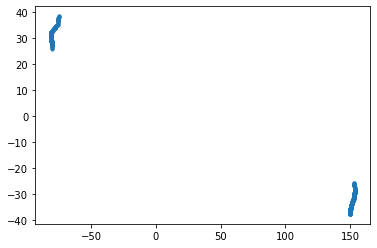

In [1058]:
plt.plot(tmp['longitude'], tmp['latitude'],'.')

In [1059]:
tmp.mstr.max()

2.5919134616851807

In [1060]:
tmp.mstr.min()

0.2812045216560364

In [1061]:
## further split into equal numbers of samples per MSTR range class

In [1062]:
# num_samples_per_category=160 
# bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 3), (3, 8)])

# tmp['category'] = pd.cut(tmp['mstr'], bins=bins)
# tmp = tmp.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = False)).reset_index(drop = True)
# tmp = tmp.dropna()
# len(tmp)

In [1063]:
bujan_path = os.path.normpath('../data/bujan_et_al_data/Size-Slope-Data-Points.csv')


bujan_dat = pd.read_csv(bujan_path)
bujan_dat#.keys()

bujan_sand = bujan_dat[bujan_dat['Clast size (mm)']<2]

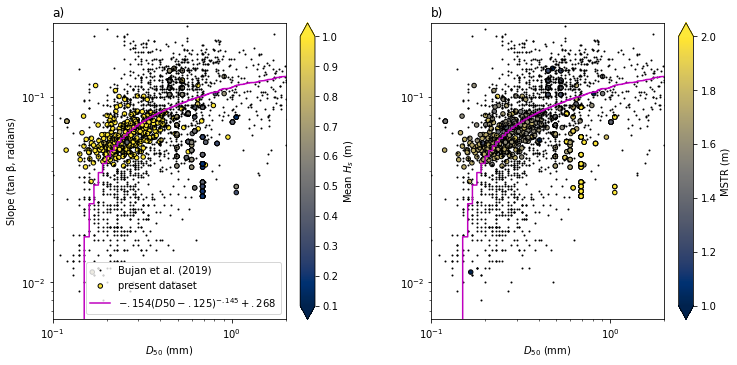

In [1257]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

plt.subplot(221)

plt.loglog(bujan_dat['Clast size (mm)'], bujan_dat['Slope (tan β)'],'ko', markersize=1, label='Bujan et al. (2019)')
# plt.scatter(gs_slope_waves['d50'], gs_slope_waves['tanBeta'],20,gs_slope_waves['hs_mean'],label='Atlantic C-GRASP')
plt.scatter(tmp['d50'], tmp['beach_slope_average'],20,tmp['Hs_mean'],label='present dataset', cmap='cividis', vmin=.1, vmax=1, lw=1,edgecolors='black')

plt.xlabel(r'$D_{50}$ (mm)')

plt.ylabel('Slope (tan β, radians)')
cb = plt.colorbar(extend='both')
plt.title("a)", loc='left')

cb.set_label(r'Mean $H_s$ (m)')

a = -0.154
b = -0.145
c = 0.268
ln = a*( bujan_dat['Clast size (mm)'] - 0.125)**b + c

plt.plot(np.sort(bujan_dat['Clast size (mm)']), np.sort(ln),'m', label=r'$-.154(D50 - .125)^{-.145} + .268$')

plt.xlim(0.1,2)
plt.ylim(10**-2.2,10**-.6)

plt.legend()


plt.subplot(222)
plt.loglog(bujan_dat['Clast size (mm)'], bujan_dat['Slope (tan β)'],'ko', markersize=1, label='Bujan et al. (2019)')
plt.scatter(tmp['d50'], tmp['beach_slope_average'],20,tmp['mstr'],label='present dataset', cmap='cividis', vmin=1, vmax=2, lw=1,edgecolors='black')

plt.xlabel(r'$D_{50}$ (mm)')

# plt.ylabel('Slope (tan β)')
cb = plt.colorbar(extend='both')

cb.set_label(r'MSTR (m)')

a = -0.154
b = -0.145
c = 0.268
ln = a*( bujan_dat['Clast size (mm)'] - 0.125)**b + c

plt.plot(np.sort(bujan_dat['Clast size (mm)']), np.sort(ln),'m', label=r'$-.154(D50 - .125)^{-.145} + .268$')
plt.title("b)", loc='left')

plt.ylim(10**-2.2,10**-.6)
plt.xlim(0.1,2)

plt.savefig('CGRASP_d50-slope-waveHs-MSTR-US-Oz.jpg', dpi=300, bbox_inches='tight')

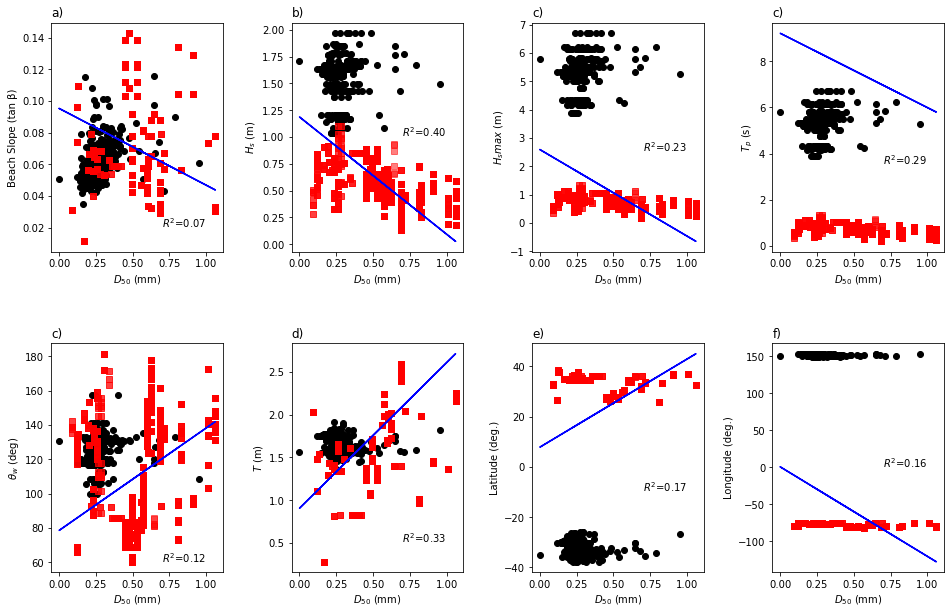

In [1267]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(341)
# plt.plot(df['d50'], df['beach_slope_average'],'k.')
plt.plot(df['d50'][df['code']==0], df['beach_slope_average'][df['code']==0], 'ko', label='Test, Aus.')
plt.plot(df['d50'][df['code']==1], df['beach_slope_average'][df['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Beach Slope (tan β)')
plt.title("a)", loc='left')

coef = np.polyfit(df['d50'], df['beach_slope_average'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')

r2 = np.min(np.corrcoef(df['d50'], df['beach_slope_average']))**2
plt.text(.7,.02,r'$R^2$='+str(r2)[:4])

plt.subplot(342)
# plt.plot(df['d50'], df['Hs_mean'],'k.')
plt.plot(df['d50'][df['code']==0], df['Hs_mean'][df['code']==0], 'ko', label='Test, Aus.')
plt.plot(df['d50'][df['code']==1], df['Hs_mean'][df['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{s}$ (m)')
plt.title("b)", loc='left')

coef = np.polyfit(df['d50'], df['Hs_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')

r2 = np.min(np.corrcoef(df['d50'], df['Hs_mean']))**2
plt.text(.7,1,r'$R^2$='+str(r2)[:4])

plt.subplot(343)
# plt.plot(df['d50'], df['Hs_max'],'k.')
plt.plot(df['d50'][df['code']==0], df['Hs_max'][df['code']==0], 'ko', label='Test, Aus.')
plt.plot(df['d50'][df['code']==1], df['Hs_max'][df['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{s} max$ (m)')
plt.title("c)", loc='left')

coef = np.polyfit(df['d50'], df['Hs_max'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')

r2 = np.min(np.corrcoef(df['d50'], df['Hs_max']))**2
plt.text(.7,2.5,r'$R^2$='+str(r2)[:4])

plt.subplot(344)
# plt.plot(df['d50'], df['Tp_mean'],'k.')
plt.plot(df['d50'][df['code']==0], df['Hs_max'][df['code']==0], 'ko', label='Test, Aus.')
plt.plot(df['d50'][df['code']==1], df['Hs_max'][df['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T_{p}$ (s)')
plt.title("c)", loc='left')

coef = np.polyfit(df['d50'], df['Tp_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')

r2 = np.min(np.corrcoef(df['d50'], df['Tp_mean']))**2
plt.text(.7,3.5,r'$R^2$='+str(r2)[:4])


plt.subplot(345)
# plt.plot(df['d50'], df['Wdir_mean'],'k.')
plt.plot(df['d50'][df['code']==0], df['Wdir_mean'][df['code']==0], 'ko', label='Test, Aus.')
plt.plot(df['d50'][df['code']==1], df['Wdir_mean'][df['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$\theta_{w}$ (deg)')
plt.title("c)", loc='left')

coef = np.polyfit(df['d50'], df['Wdir_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')

r2 = np.min(np.corrcoef(df['d50'], df['Wdir_mean']))**2
plt.text(.7,60,r'$R^2$='+str(r2)[:4])

plt.subplot(346)
# plt.plot(df['d50'], df['mstr'],'k.')
plt.plot(df['d50'][df['code']==0], df['mstr'][df['code']==0], 'ko', label='Test, Aus.')
plt.plot(df['d50'][df['code']==1], df['mstr'][df['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T$ (m)')
plt.title("d)", loc='left')

coef = np.polyfit(df['d50'], df['mstr'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')

r2 = np.min(np.corrcoef(df['d50'], df['mstr']))**2
plt.text(.7,.5,r'$R^2$='+str(r2)[:4])

plt.subplot(347)
# plt.plot(df['d50'], df['latitude'],'k.')
plt.plot(df['d50'][df['code']==0], df['latitude'][df['code']==0], 'ko', label='Test, Aus.')
plt.plot(df['d50'][df['code']==1], df['latitude'][df['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Latitude (deg.)')
plt.title("e)", loc='left')

coef = np.polyfit(df['d50'], df['latitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')

r2 = np.min(np.corrcoef(df['d50'], df['latitude']))**2
plt.text(.7,-10,r'$R^2$='+str(r2)[:4])

plt.subplot(348)
# plt.plot(df['d50'], df['longitude'],'k.')
plt.plot(df['d50'][df['code']==0], df['longitude'][df['code']==0], 'ko', label='Test, Aus.')
plt.plot(df['d50'][df['code']==1], df['longitude'][df['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Longitude (deg.)')
plt.title("f)", loc='left')

coef = np.polyfit(df['d50'], df['longitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')

r2 = np.min(np.corrcoef(df['d50'], df['longitude']))**2
plt.text(.7,0,r'$R^2$='+str(r2)[:4])

plt.savefig('CGRASP_d50-allcovars-linreg-US-Oz.jpg', dpi=300, bbox_inches='tight')

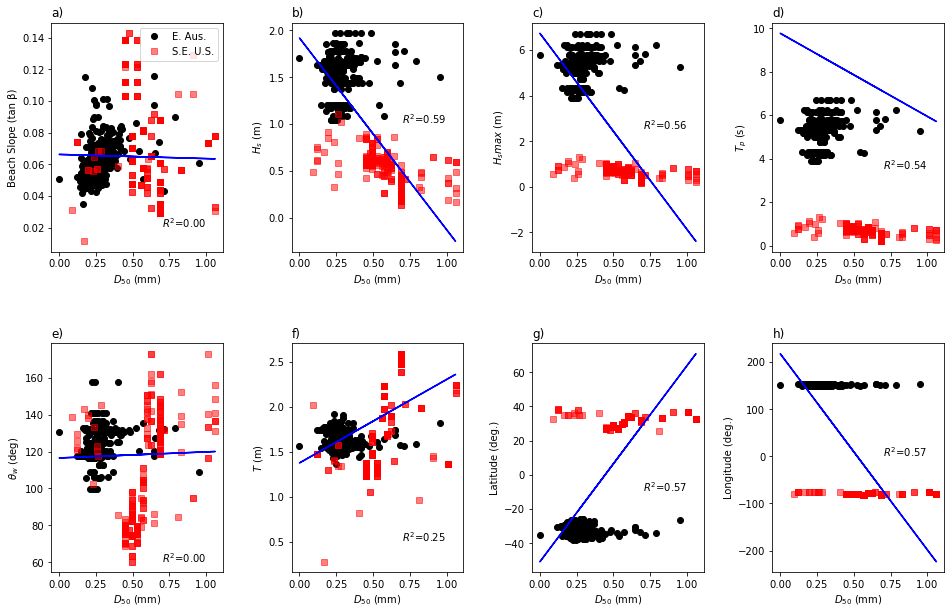

In [1320]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(341)
# plt.plot(tmp['d50'], tmp['beach_slope_average'],'k.')
plt.plot(tmp['d50'][tmp['code']==0], tmp['beach_slope_average'][tmp['code']==0], 'ko', label='E. Aus.')
plt.plot(tmp['d50'][tmp['code']==1], tmp['beach_slope_average'][tmp['code']==1], 'rs',alpha=0.5, label='S.E. U.S.')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Beach Slope (tan β)')
plt.title("a)", loc='left')

coef = np.polyfit(tmp['d50'], tmp['beach_slope_average'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-b')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['beach_slope_average']))**2
plt.text(.7,.02,r'$R^2$='+str(r2)[:4])

plt.legend(loc=1)

plt.subplot(342)
# plt.plot(tmp['d50'], tmp['Hs_mean'],'k.')
plt.plot(tmp['d50'][tmp['code']==0], tmp['Hs_mean'][tmp['code']==0], 'ko', label='Test, Aus.')
plt.plot(tmp['d50'][tmp['code']==1], tmp['Hs_mean'][tmp['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{s}$ (m)')
plt.title("b)", loc='left')

coef = np.polyfit(tmp['d50'], tmp['Hs_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-b')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['Hs_mean']))**2
plt.text(.7,1,r'$R^2$='+str(r2)[:4])

plt.subplot(343)
# plt.plot(tmp['d50'], tmp['Hs_max'],'k.')
plt.plot(tmp['d50'][tmp['code']==0], tmp['Hs_max'][tmp['code']==0], 'ko', label='Test, Aus.')
plt.plot(tmp['d50'][tmp['code']==1], tmp['Hs_max'][tmp['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{s} max$ (m)')
plt.title("c)", loc='left')

coef = np.polyfit(tmp['d50'], tmp['Hs_max'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-b')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['Hs_max']))**2
plt.text(.7,2.5,r'$R^2$='+str(r2)[:4])

plt.subplot(344)
# plt.plot(tmp['d50'], tmp['Tp_mean'],'k.')
plt.plot(tmp['d50'][tmp['code']==0], tmp['Hs_max'][tmp['code']==0], 'ko', label='Test, Aus.')
plt.plot(tmp['d50'][tmp['code']==1], tmp['Hs_max'][tmp['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T_{p}$ (s)')
plt.title("d)", loc='left')

coef = np.polyfit(tmp['d50'], tmp['Tp_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-b')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['Tp_mean']))**2
plt.text(.7,3.5,r'$R^2$='+str(r2)[:4])

plt.subplot(345)
# plt.plot(tmp['d50'], tmp['Wdir_mean'],'k.')
plt.plot(tmp['d50'][tmp['code']==0], tmp['Wdir_mean'][tmp['code']==0], 'ko', label='Test, Aus.')
plt.plot(tmp['d50'][tmp['code']==1], tmp['Wdir_mean'][tmp['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$\theta_{w}$ (deg)')
plt.title("e)", loc='left')

coef = np.polyfit(tmp['d50'], tmp['Wdir_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-b')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['Wdir_mean']))**2
plt.text(.7,60,r'$R^2$='+str(r2)[:4])

plt.subplot(346)
# plt.plot(tmp['d50'], tmp['mstr'],'k.')
plt.plot(tmp['d50'][tmp['code']==0], tmp['mstr'][tmp['code']==0], 'ko', label='Test, Aus.')
plt.plot(tmp['d50'][tmp['code']==1], tmp['mstr'][tmp['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T$ (m)')
plt.title("f)", loc='left')

coef = np.polyfit(tmp['d50'], tmp['mstr'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-b')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['mstr']))**2
plt.text(.7,.5,r'$R^2$='+str(r2)[:4])

plt.subplot(347)
# plt.plot(tmp['d50'], tmp['latitude'],'k.')
plt.plot(tmp['d50'][tmp['code']==0], tmp['latitude'][tmp['code']==0], 'ko', label='Test, Aus.')
plt.plot(tmp['d50'][tmp['code']==1], tmp['latitude'][tmp['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Latitude (deg.)')
plt.title("g)", loc='left')

coef = np.polyfit(tmp['d50'], tmp['latitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-b')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['latitude']))**2
plt.text(.7,-10,r'$R^2$='+str(r2)[:4])

plt.subplot(348)
# plt.plot(tmp['d50'], tmp['longitude'],'k.')
plt.plot(tmp['d50'][tmp['code']==0], tmp['longitude'][tmp['code']==0], 'ko', label='Test, Aus.')
plt.plot(tmp['d50'][tmp['code']==1], tmp['longitude'][tmp['code']==1], 'rs',alpha=0.5, label='Test, US. S.Atlantic')

plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Longitude (deg.)')
plt.title("h)", loc='left')

coef = np.polyfit(tmp['d50'], tmp['longitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-b')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['longitude']))**2
plt.text(.7,0,r'$R^2$='+str(r2)[:4])

plt.savefig('CGRASP_d50-allcovars-linreg-US-Oz_sample.jpg', dpi=300, bbox_inches='tight')

In [1268]:
X = pg.pairwise_corr(tmp[['beach_slope_average','d50','mstr','Tp_mean','Wdir_mean','Hs_max']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

In [1269]:
len(tmp)

544

In [1270]:
ind = np.where((tmp['mstr']>1) & (tmp['mstr']<4))[0]
len(ind)
df_meso = tmp.iloc[ind]
len(df_meso)

541

In [1271]:
Xmeso = pg.pairwise_corr(df_meso[['beach_slope_average','d50','mstr','Tp_mean','Wdir_mean','Hs_max']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

In [1272]:
ind = np.where(tmp['mstr']<1)[0]
len(ind)
df_micro = tmp.iloc[ind]
len(df_micro)

3

In [1273]:
Xmicro = pg.pairwise_corr(df_micro[['beach_slope_average','d50','mstr','Tp_mean','Wdir_mean','Hs_max']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\pingouin\correlation.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  tval = r * np.sqrt(dof / (1 - r**2))
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\pingouin\correlation.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  tval = r * np.sqrt(dof / (1 - r**2))
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\pingouin\effsize.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  se = 1 / np.sqrt(nx - 3)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\pingouin\power.py:896: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power "
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\pingouin\correlation.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  tval = r * np.sqrt(dof / (1 - r**2))
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\l

In [1274]:
ind = np.where(tmp['mstr']>4)[0]
len(ind)
df_macro = tmp.iloc[ind]
len(df_macro)

0

In [1275]:
len(tmp)

544

In [1276]:
# Xmacro = pg.pairwise_corr(df_macro[['beach_slope_average','d50','mstr','Tp_mean','Wdir_mean','Hs_max']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

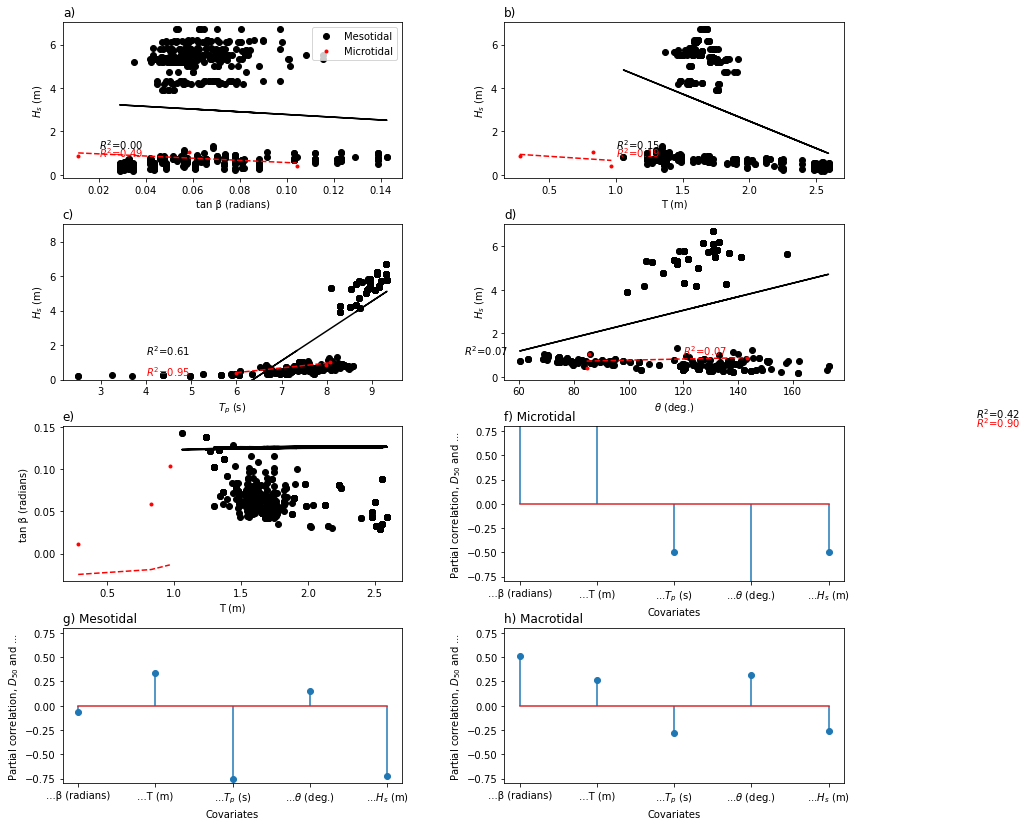

In [1277]:
plt.figure(figsize=(14,14))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#=================================
# plt.subplot(331)
plt.subplot(421)
plt.plot(tmp['beach_slope_average'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],'ko', label='Mesotidal')
plt.plot(tmp['beach_slope_average'][tmp['mstr']<1],tmp['Hs_max'][tmp['mstr']<1],'r.', label='Microtidal')
# plt.plot(tmp['beach_slope_average'][tmp['mstr']>4],tmp['Hs_max'][tmp['mstr']>4],'b*', label='Macrotidal')

coef = np.polyfit(tmp['beach_slope_average'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['beach_slope_average'][(tmp['mstr']>=1) & (tmp['mstr']<=4)], poly1d_fn(tmp['beach_slope_average'][(tmp['mstr']>=1) & (tmp['mstr']<=4)]), '-k')

coef = np.polyfit(tmp['beach_slope_average'][tmp['mstr']<1],tmp['Hs_max'][tmp['mstr']<1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(sorted(tmp['beach_slope_average'][tmp['mstr']<1]), poly1d_fn(sorted(tmp['beach_slope_average'][tmp['mstr']<1])), '--r')

# coef = np.polyfit(tmp['beach_slope_average'][tmp['mstr']>4],tmp['Hs_max'][tmp['mstr']>4],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(sorted(tmp['beach_slope_average'][tmp['mstr']>4]), poly1d_fn(sorted(tmp['beach_slope_average'][tmp['mstr']>4])), '--b')

r2 = np.min(np.corrcoef(tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)], tmp['beach_slope_average'][(tmp['mstr']>=1) & (tmp['mstr']<=4)]))**2
plt.text(.02,1.2,r'$R^2$='+str(r2)[:4])

r2 = np.min(np.corrcoef(tmp['Hs_max'][tmp['mstr']<1], tmp['beach_slope_average'][tmp['mstr']<1]))**2
plt.text(.02,.8,r'$R^2$='+str(r2)[:4], color='r')

# r2 = np.min(np.corrcoef(tmp['Hs_max'][tmp['mstr']>4], tmp['beach_slope_average'][tmp['mstr']>4]))**2
# plt.text(.02,1.6,r'$R^2$='+str(r2)[:4], color='b')

plt.ylabel(r'$H_s$ (m)')
plt.xlabel(r'tan β (radians)')
plt.title(r"a)", loc='left')
plt.legend()

#================================
# plt.subplot(332)
plt.subplot(422)
plt.plot(tmp['mstr'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],'ko')
plt.plot(tmp['mstr'][tmp['mstr']<1],tmp['Hs_max'][tmp['mstr']<1],'r.')
# plt.plot(tmp['mstr'][tmp['mstr']>4],tmp['Hs_max'][tmp['mstr']>4],'b*')

coef = np.polyfit(tmp['mstr'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['mstr'][(tmp['mstr']>=1) & (tmp['mstr']<=4)], poly1d_fn(tmp['mstr'][(tmp['mstr']>=1) & (tmp['mstr']<=4)]), '-k')

coef = np.polyfit(tmp['mstr'][tmp['mstr']<1],tmp['Hs_max'][tmp['mstr']<1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(sorted(tmp['mstr'][tmp['mstr']<1]), poly1d_fn(sorted(tmp['mstr'][tmp['mstr']<1])), '--r')

# coef = np.polyfit(tmp['mstr'][tmp['mstr']>=4],tmp['Hs_max'][tmp['mstr']>=4],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(sorted(tmp['mstr'][tmp['mstr']>=4]), poly1d_fn(sorted(tmp['mstr'][tmp['mstr']>=4])), '--b')

r2 = np.min(np.corrcoef(tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)], tmp['mstr'][(tmp['mstr']>=1) & (tmp['mstr']<=4)]))**2
plt.text(1,1.2,r'$R^2$='+str(r2)[:4])

r2 = np.min(np.corrcoef(tmp['Hs_max'][tmp['mstr']<1], tmp['mstr'][tmp['mstr']<1]))**2
plt.text(1,.8,r'$R^2$='+str(r2)[:4], color='r')

# r2 = np.min(np.corrcoef(tmp['Hs_max'][tmp['mstr']>=4], tmp['mstr'][tmp['mstr']>=4]))**2
# plt.text(1,1.6,r'$R^2$='+str(r2)[:4], color='b')

plt.ylabel(r'$H_s$ (m)')
plt.xlabel(r'T (m)')
plt.title(r"b)", loc='left')

#=================================
# plt.subplot(334)
plt.subplot(423)
plt.plot(tmp['Tp_mean'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],'ko')
plt.plot(tmp['Tp_mean'][tmp['mstr']<1],tmp['Hs_max'][tmp['mstr']<1],'r.')
# plt.plot(tmp['Tp_mean'][tmp['mstr']>4],tmp['Hs_max'][tmp['mstr']>4],'b*')

coef = np.polyfit(tmp['Tp_mean'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['Tp_mean'][tmp['mstr']>=1], poly1d_fn(tmp['Tp_mean'][tmp['mstr']>=1]), '-k')

coef = np.polyfit(tmp['Tp_mean'][tmp['mstr']<1],tmp['Hs_max'][tmp['mstr']<1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(sorted(tmp['Tp_mean'][tmp['mstr']<1]), poly1d_fn(sorted(tmp['Tp_mean'][tmp['mstr']<1])), '--r')

# coef = np.polyfit(tmp['Tp_mean'][tmp['mstr']>1],tmp['Hs_max'][tmp['mstr']>1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(sorted(tmp['Tp_mean'][tmp['mstr']>1]), poly1d_fn(sorted(tmp['Tp_mean'][tmp['mstr']>1])), '--b')

r2 = np.min(np.corrcoef(tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)], tmp['Tp_mean'][(tmp['mstr']>=1) & (tmp['mstr']<=4)]))**2
plt.text(4,1.4,r'$R^2$='+str(r2)[:4])

r2 = np.min(np.corrcoef(tmp['Hs_max'][tmp['mstr']<1], tmp['Tp_mean'][tmp['mstr']<1]))**2
plt.text(4,.2,r'$R^2$='+str(r2)[:4], color='r')

# r2 = np.min(np.corrcoef(tmp['Hs_max'][tmp['mstr']>1], tmp['Tp_mean'][tmp['mstr']>1]))**2
# plt.text(4,.8,r'$R^2$='+str(r2)[:4], color='b')

plt.ylabel(r'$H_s$ (m)')
plt.xlabel(r'$T_p$ (s)')
plt.title(r"c)", loc='left')
plt.ylim(0,9)

#=================================
# plt.subplot(335)
plt.subplot(424)
plt.plot(tmp['Wdir_mean'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],'ko')
plt.plot(tmp['Wdir_mean'][tmp['mstr']<1],tmp['Hs_max'][tmp['mstr']<1],'r.')
# plt.plot(tmp['Wdir_mean'][tmp['mstr']>4],tmp['Hs_max'][tmp['mstr']>4],'b*')

coef = np.polyfit(tmp['Wdir_mean'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['Wdir_mean'][(tmp['mstr']>=1) & (tmp['mstr']<=4)], poly1d_fn(tmp['Wdir_mean'][(tmp['mstr']>=1) & (tmp['mstr']<=4)]), '-k')

coef = np.polyfit(tmp['Wdir_mean'][tmp['mstr']<1],tmp['Hs_max'][tmp['mstr']<1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(sorted(tmp['Wdir_mean'][tmp['mstr']<1]), poly1d_fn(sorted(tmp['Wdir_mean'][tmp['mstr']<1])), '--r')

# coef = np.polyfit(tmp['Wdir_mean'][tmp['mstr']>4],tmp['Hs_max'][tmp['mstr']>4],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(sorted(tmp['Wdir_mean'][tmp['mstr']>4]), poly1d_fn(sorted(tmp['Wdir_mean'][tmp['mstr']>4])), '--b')

r2 = np.min(np.corrcoef(tmp['Hs_max'][(tmp['mstr']>=1) & (tmp['mstr']<=4)], tmp['Wdir_mean'][(tmp['mstr']>=1) & (tmp['mstr']<=4)]))**2
plt.text(40,1,r'$R^2$='+str(r2)[:4])

r2 = np.min(np.corrcoef(tmp['Hs_max'][tmp['mstr']<1], tmp['Wdir_mean'][tmp['mstr']<1]))**2
plt.text(120,1,r'$R^2$='+str(r2)[:4], color='r')

# r2 = np.min(np.corrcoef(tmp['Hs_max'][tmp['mstr']>4], tmp['Wdir_mean'][tmp['mstr']>4]))**2
# plt.text(200,1,r'$R^2$='+str(r2)[:4], color='b')

plt.ylabel(r'$H_s$ (m)')
plt.xlabel(r'$\theta$ (deg.)')
plt.title(r"d)", loc='left')

#=================================
# plt.subplot(233)
plt.subplot(425)
plt.plot(tmp['mstr'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],tmp['beach_slope_average'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],'ko')
plt.plot(tmp['mstr'][tmp['mstr']<1],tmp['beach_slope_average'][tmp['mstr']<1],'r.')
# plt.plot(tmp['mstr'][tmp['mstr']>4],tmp['beach_slope_average'][tmp['mstr']>4],'b*')

coef = np.polyfit(tmp['mstr'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],tmp['beach_slope_average'][(tmp['mstr']>=1) & (tmp['mstr']<=4)],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['mstr'][(tmp['mstr']>=1) & (tmp['mstr']<=4)], poly1d_fn(tmp['beach_slope_average'][(tmp['mstr']>=1) & (tmp['mstr']<=4)]), '-k')

# coef = np.polyfit(tmp['mstr'][(tmp['mstr']<1)],tmp['beach_slope_average'][(tmp['mstr']<1)],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(tmp['mstr'][(tmp['mstr']<1)], poly1d_fn(tmp['beach_slope_average'][(tmp['mstr']<1)]), '--r')

# coef = np.polyfit(tmp['mstr'][(tmp['mstr']>4)],tmp['beach_slope_average'][(tmp['mstr']>4)],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(tmp['mstr'][(tmp['mstr']>4)], poly1d_fn(tmp['beach_slope_average'][(tmp['mstr']>4)]), '--b')

coef = np.polyfit(tmp['mstr'][tmp['mstr']<1],tmp['beach_slope_average'][tmp['mstr']<1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(sorted(tmp['mstr'][tmp['mstr']<1]), poly1d_fn(sorted(tmp['beach_slope_average'][tmp['mstr']<1])), '--r')

# coef = np.polyfit(tmp['mstr'][tmp['mstr']>4],tmp['beach_slope_average'][tmp['mstr']>4],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(sorted(tmp['mstr'][tmp['mstr']>4]), poly1d_fn(sorted(tmp['beach_slope_average'][tmp['mstr']>4])), '--b')


r2 = np.min(np.corrcoef(tmp['beach_slope_average'][(tmp['mstr']>=1) & (tmp['mstr']<=4)], tmp['mstr'][(tmp['mstr']>=1) & (tmp['mstr']<=4)]))**2
plt.text(7,0.16,r'$R^2$='+str(.1+r2)[:4])

r2 = np.min(np.corrcoef(tmp['beach_slope_average'][tmp['mstr']<1], tmp['mstr'][tmp['mstr']<1]))**2
plt.text(7,0.15,r'$R^2$='+str(r2)[:4], color='r')

# r2 = np.min(np.corrcoef(tmp['beach_slope_average'][tmp['mstr']>4], tmp['mstr'][tmp['mstr']>4]))**2
# plt.text(7,0.17,r'$R^2$='+str(r2)[:4], color='b')

plt.ylabel(r'tan β (radians)')
plt.xlabel(r'T (m)')
plt.title(r"e)", loc='left')

#=================================
ax=plt.subplot(426)
plt.stem(Xmicro['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)','...T (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-.8,.8)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"f) Microtidal", loc='left')

#=================================
ax=plt.subplot(427)
plt.stem(Xmeso['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)','...T (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-.8,.8)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"g) Mesotidal", loc='left')

#=================================
ax=plt.subplot(428)
plt.stem(Xmacro['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)','...T (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-.8,.8)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"h) Macrotidal", loc='left')

plt.savefig('multicol_plus_partial_correl_US_Oz.jpg', dpi=300, bbox_inches='tight')

In [1284]:
len(df_meso)

541

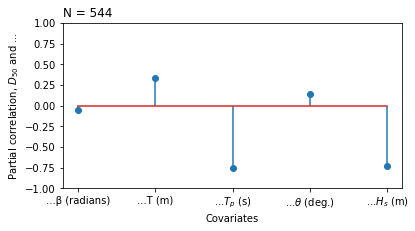

In [1292]:
plt.figure(figsize=(14,7))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# #==================
# #=================================
# ax=plt.subplot(221)
# plt.stem(Xmicro['r'])
# # plt.stem(lower)
# # plt.stem(upper)
# plt.xticks([0,1,2,3,4])
# ax.set_xticklabels(['...β (radians)','...T (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
# plt.ylim(-1,1)
# plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
# plt.xlabel(r'Covariates')
# plt.title(r"a) Microtidal (N = {})".format(len(df_micro)), loc='left')

# #=================================
# ax=plt.subplot(222)
# plt.stem(Xmeso['r'])
# # plt.stem(lower)
# # plt.stem(upper)
# plt.xticks([0,1,2,3,4])
# ax.set_xticklabels(['...β (radians)','...T (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
# plt.ylim(-1,1)
# plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
# plt.xlabel(r'Covariates')
# plt.title(r"b) Mesotidal (N = {})".format(len(df_meso)), loc='left')

# #=================================
# ax=plt.subplot(223)
# plt.stem(Xmacro['r'])
# # plt.stem(lower)
# # plt.stem(upper)
# plt.xticks([0,1,2,3,4])
# ax.set_xticklabels(['...β (radians)','...T (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
# plt.ylim(-1,1)
# plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
# plt.xlabel(r'Covariates')
# plt.title(r"c) Macrotidal (N = {})".format(len(df_micro)), loc='left')

#=================================
ax=plt.subplot(221)
plt.stem(X['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)','...T (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-1,1)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"N = {}".format(len(tmp)), loc='left')

plt.savefig('partial_correl_US_Oz.jpg', dpi=300, bbox_inches='tight')

In [1293]:
# plt.plot(df_macro['longitude'],df_macro['latitude'],'b*')
# plt.plot(df_meso['longitude'],df_meso['latitude'],'ko')
# plt.plot(df_micro['longitude'],df_micro['latitude'],'r.')

### baseline

In [1294]:
a = -0.154
b = -0.145
c = 0.268

def mcfall(X,hs):
    if hs<=1:
        A = 3.1; n = -1.1 
    elif hs>=3:
        A = 3.9; n = -1.85         
    else:
        A = 2.1; n = -1.8             
    return (X/A)**(1/n)

def prc_err(y,yest):
    return 100*(np.abs(y-yest)/y)

def bujan(B,a,b,c):
    t1=(B-c)
    return (1/8)*(8*((t1/a))**(1/b)+1)


In [1297]:
tmp_meso = df_meso.copy()
tmp_micro = df_micro.copy()
# tmp_macro = df_macro.copy()

len(tmp)

544

In [1299]:
# tmp = tmp.dropna()
# len(tmp)

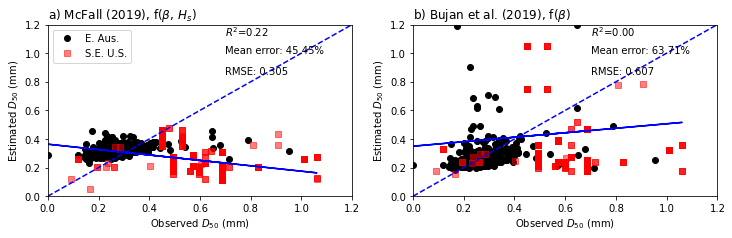

In [1317]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

#========================================

ds_est_baseline = np.array([mcfall(X,hs) for X,hs in zip(1/tmp['beach_slope_average'],tmp['Hs_mean'])])
ds_est_baseline2 = np.array([bujan(B,a,b,c) for B in tmp['beach_slope_average']])



plt.subplot(321)
# plt.plot(tmp['d50'], ds_est_baseline, 'ko', label=r'')

plt.plot(tmp['d50'][tmp['code']==0], ds_est_baseline[tmp['code']==0], 'ko', label='E. Aus.')
plt.plot(tmp['d50'][tmp['code']==1], ds_est_baseline[tmp['code']==1], 'rs',alpha=0.5, label='S.E. U.S.')

plt.xlim(0,1.2); plt.ylim(0,1.2)

yl=plt.ylim()
plt.plot(yl,yl,'--b')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) McFall (2019), f($\beta$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(tmp['d50'], ds_est_baseline))**2
plt.text(.7,1.12,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(tmp['d50'], ds_est_baseline,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-b')
plt.legend()

pe = prc_err(tmp['d50'], ds_est_baseline)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]

plt.text(.7,1, r'Mean error: {}%'.format(str(np.nanmean(pe))[:5]))

rmse = np.sqrt(np.mean((tmp['d50']-ds_est_baseline)**2))

plt.text(.7,.85, r'RMSE: {}'.format(str(rmse)[:5]))

plt.subplot(322)
# plt.plot(tmp['d50'], ds_est_baseline2, 'rs', alpha=0.5, label=r"Bujan et al. (2019), f($\beta$)")
plt.plot(tmp['d50'][tmp['code']==0], ds_est_baseline2[tmp['code']==0], 'ko', label='E. Aus.')
plt.plot(tmp['d50'][tmp['code']==1], ds_est_baseline2[tmp['code']==1], 'rs',alpha=0.5, label='S.E. U.S.')

plt.xlim(0,1.2); plt.ylim(0,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--b')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) Bujan et al. (2019), f($\beta$)", loc='left') #Bujan et al. (2019) relation, f($\beta$)
r2 = np.min(np.corrcoef(tmp['d50'], ds_est_baseline2))**2
plt.text(.7,1.12,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(tmp['d50'], ds_est_baseline2,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-b')
# plt.legend()

pe = prc_err(tmp['d50'], ds_est_baseline2)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]

plt.text(.7,1.0, r'Mean error: {}%'.format(str(np.nanmean(pe))[:5]))

rmse = np.sqrt(np.mean((tmp['d50']-ds_est_baseline2)**2))

plt.text(.7,.85, r'RMSE: {}'.format(str(rmse)[:5]))


plt.savefig('CGRASP_d50_US-Oz-baselines.jpg', dpi=300, bbox_inches='tight')
# plt.close()

### all tides

In [2017]:
params = {
    "n_estimators": 30000,
    "max_depth": 5, #4,
    "min_samples_split": 10, #10,
    "learning_rate": 0.0001, #1, #0.01,
    "loss": "squared_error",
    "subsample": 0.5,
}

# # ### xgboost
# xparams = {
#     'n_estimators':5000, 
#     'max_depth':3, 
#     'eta':0.001,  ##lr
#     'subsample':0.25, 
#     'colsample_bytree':1.0
# }

test_size = 0.75

In [2018]:
rand = np.random.randn(len(tmp))
np.save('USOz_rand.npy', rand, allow_pickle=True)

In [2019]:
len(tmp)

544

In [2165]:
#0=Oz, 1=US
np.bincount(tmp['code'])

array([272, 272], dtype=int64)

In [2166]:
yscaler = preprocessing.StandardScaler().fit(tmp['d50'].values.reshape(-1, 1))
y = yscaler.transform(tmp['d50'].values.reshape(-1, 1))

indices = np.arange(len(y))

In [2167]:
feature_names1 = ['β (radians)',r'$H_s$ (m)', 'T (m)',r'$T_p$ (s)', r'$\theta$ (dir.)','Random (non-dim.)'] 
X = np.stack((tmp['beach_slope_average'],tmp['Hs_max'],tmp['mstr'] ,tmp['Tp_mean'],tmp['Wdir_mean'],  rand)) 
X.shape

X_train1, X_test1, y_train1, y_test1, indices_train1, indices_test1 = train_test_split(
    X.T, y.ravel() , indices, test_size=test_size, random_state=2022, 
)

#unscale y - we balanced it to sample equally among grain size bins
y_test1 = yscaler.inverse_transform(y_test1.reshape(-1, 1)).squeeze()
y_train1 = yscaler.inverse_transform(y_train1.reshape(-1, 1)).squeeze()

print(y_test1.max())
print(y_train1.max())

#scale x
# scaler = preprocessing.StandardScaler().fit(X_train1)
# X_train1 = scaler.transform(X_train1)
# X_test1 = scaler.transform(X_test1)

# model1 = xgb.XGBRFRegressor(**xparams)
model1 = ensemble.GradientBoostingRegressor(**params)
# model1 = ensemble.HistGradientBoostingRegressor()#**params)
model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0114


In [2168]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.457 (0.070)


In [2169]:
combo_model1out = {}
combo_model1out['feature_names'] = feature_names1
combo_model1out['Xtest'] = X_test1
combo_model1out['Xtrain'] = X_train1
combo_model1out['ytest'] = y_test1
combo_model1out['ytrain'] = y_train1
combo_model1out['model'] = model1
combo_model1out['mse'] = mse1
combo_model1out['rmse_mean_xval'] = scores.mean()
combo_model1out['rmse_std_xval'] = scores.std()

In [2170]:
feature_names2 = [r'β (radians)','T (m)', 'Random (non-dim.)']
X = np.stack((tmp['beach_slope_average'],tmp['mstr'], rand))
X.shape

X_train2, X_test2, y_train2, y_test2, indices_train2, indices_test2 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test2 = yscaler.inverse_transform(y_test2.reshape(-1, 1)).squeeze()
y_train2 = yscaler.inverse_transform(y_train2.reshape(-1, 1)).squeeze()

print(y_test2.max())
print(y_train2.max())

# scaler = preprocessing.StandardScaler().fit(X_train2)
# X_train2 = scaler.transform(X_train2)
# X_test2 = scaler.transform(X_test2)

# model2 = svm.SVR()
# model2 = xgb.XGBRFRegressor(**xparams)
model2 = ensemble.GradientBoostingRegressor(**params)
# model2 = ensemble.HistGradientBoostingRegressor()#**params)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0174


In [2171]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.530 (0.053)


In [2172]:
combo_model2out = {}
combo_model2out['feature_names'] = feature_names2
combo_model2out['Xtest'] = X_test2
combo_model2out['Xtrain'] = X_train2
combo_model2out['ytest'] = y_test2
combo_model2out['ytrain'] = y_train2
combo_model2out['model'] = model2
combo_model2out['mse'] = mse2
combo_model2out['rmse_mean_xval'] = scores.mean()
combo_model2out['rmse_std_xval'] = scores.std()

In [2173]:
feature_names3 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)', 'Random (non-dim.)'] #
X = np.stack((tmp['Hs_max'],tmp['Tp_mean'],tmp['Wdir_mean'], rand)) 
X.shape

X_train3, X_test3, y_train3, y_test3, indices_train3, indices_test3 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test3 = yscaler.inverse_transform(y_test3.reshape(-1, 1)).squeeze()
y_train3 = yscaler.inverse_transform(y_train3.reshape(-1, 1)).squeeze()

print(y_test3.max())
print(y_train3.max())

# scaler = preprocessing.StandardScaler().fit(X_train3)
# X_train3 = scaler.transform(X_train3)
# X_test3 = scaler.transform(X_test3)

# model3 = xgb.XGBRFRegressor(**xparams)
# model3 = ensemble.HistGradientBoostingRegressor()#**params)
model3 = ensemble.GradientBoostingRegressor(**params)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0122


In [2174]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.507 (0.076)


In [2175]:
combo_model3out = {}
combo_model3out['feature_names'] = feature_names3
combo_model3out['Xtest'] = X_test3
combo_model3out['Xtrain'] = X_train3
combo_model3out['ytest'] = y_test3
combo_model3out['ytrain'] = y_train3
combo_model3out['model'] = model3
combo_model3out['mse'] = mse3
combo_model3out['rmse_mean_xval'] = scores.mean()
combo_model3out['rmse_std_xval'] = scores.std()

In [2176]:
feature_names4 = [r'$H_s$ (m)', 'T (m)',r'$T_p$ (s)', r'$\theta$ (dir.)', 'Random (non-dim.)'] #
X = np.stack((tmp['Hs_max'],tmp['mstr'] ,tmp['Tp_mean'],tmp['Wdir_mean'], rand)) 
X.shape

X_train4, X_test4, y_train4, y_test4, indices_train4, indices_test4 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test4 = yscaler.inverse_transform(y_test4.reshape(-1, 1)).squeeze()
y_train4 = yscaler.inverse_transform(y_train4.reshape(-1, 1)).squeeze()

print(y_test4.max())
print(y_train4.max())

# scaler = preprocessing.StandardScaler().fit(X_train4)
# X_train4 = scaler.transform(X_train4)
# X_test4 = scaler.transform(X_test4)

# model4 = xgb.XGBRFRegressor(**params)
model4 = ensemble.GradientBoostingRegressor(**params)
# model4 = ensemble.HistGradientBoostingRegressor()#**params)
model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0110


In [2177]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.453 (0.073)


In [2178]:
combo_model4out = {}
combo_model4out['feature_names'] = feature_names4
combo_model4out['Xtest'] = X_test4
combo_model4out['Xtrain'] = X_train4
combo_model4out['ytest'] = y_test4
combo_model4out['ytrain'] = y_train4
combo_model4out['model'] = model4
combo_model4out['mse'] = mse4
combo_model4out['rmse_mean_xval'] = scores.mean()
combo_model4out['rmse_std_xval'] = scores.std()

In [2179]:
feature_names6 = [r'β (radians)', r'$H_s$ (m)', 'Random (non-dim.)']
X = np.stack((tmp['beach_slope_average'], tmp['Hs_max'], rand))
X.shape

X_train6, X_test6, y_train6, y_test6, indices_train6, indices_test6 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test6 = yscaler.inverse_transform(y_test6.reshape(-1, 1)).squeeze()
y_train6 = yscaler.inverse_transform(y_train6.reshape(-1, 1)).squeeze()

print(y_test6.max())
print(y_train6.max())

# scaler = preprocessing.StandardScaler().fit(X_train6)
# X_train6 = scaler.transform(X_train6)
# X_test6 = scaler.transform(X_test6)

# model6 = xgb.XGBRFRegressor(**params)
# model6 = ensemble.HistGradientBoostingRegressor()#**params)
model6 = ensemble.GradientBoostingRegressor(**params)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6, model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0148


In [2180]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.536 (0.088)


In [2181]:
combo_model6out = {}
combo_model6out['feature_names'] = feature_names6
combo_model6out['Xtest'] = X_test6
combo_model6out['Xtrain'] = X_train6
combo_model6out['ytest'] = y_test6
combo_model6out['ytrain'] = y_train6
combo_model6out['model'] = model6
combo_model6out['mse'] = mse6
combo_model6out['rmse_mean_xval'] = scores.mean()
combo_model6out['rmse_std_xval'] = scores.std()

In [2182]:
feature_names7 = [r'β (radians)', 'Random (non-dim.)']
X = np.stack((tmp['beach_slope_average'], rand))
X.shape

X_train7, X_test7, y_train7, y_test7, indices_train7, indices_test7 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test7 = yscaler.inverse_transform(y_test7.reshape(-1, 1)).squeeze()
y_train7 = yscaler.inverse_transform(y_train7.reshape(-1, 1)).squeeze()

print(y_test7.max())
print(y_train7.max())

# scaler = preprocessing.StandardScaler().fit(X_train7)
# X_train7 = scaler.transform(X_train7)
# X_test7 = scaler.transform(X_test7)

# model7 = xgb.XGBRFRegressor(**params)
# model7 = ensemble.HistGradientBoostingRegressor()#**params)
model7 = ensemble.GradientBoostingRegressor(**params)
model7.fit(X_train7, y_train7)

mse7 = mean_squared_error(y_test7, model7.predict(X_test7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse7))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0304


In [2183]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model7, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.753 (0.053)


In [2184]:
combo_model7out = {}
combo_model7out['feature_names'] = feature_names7
combo_model7out['Xtest'] = X_test7
combo_model7out['Xtrain'] = X_train7
combo_model7out['ytest'] = y_test7
combo_model7out['ytrain'] = y_train7
combo_model7out['model'] = model7
combo_model7out['mse'] = mse7
combo_model7out['rmse_mean_xval'] = scores.mean()
combo_model7out['rmse_std_xval'] = scores.std()

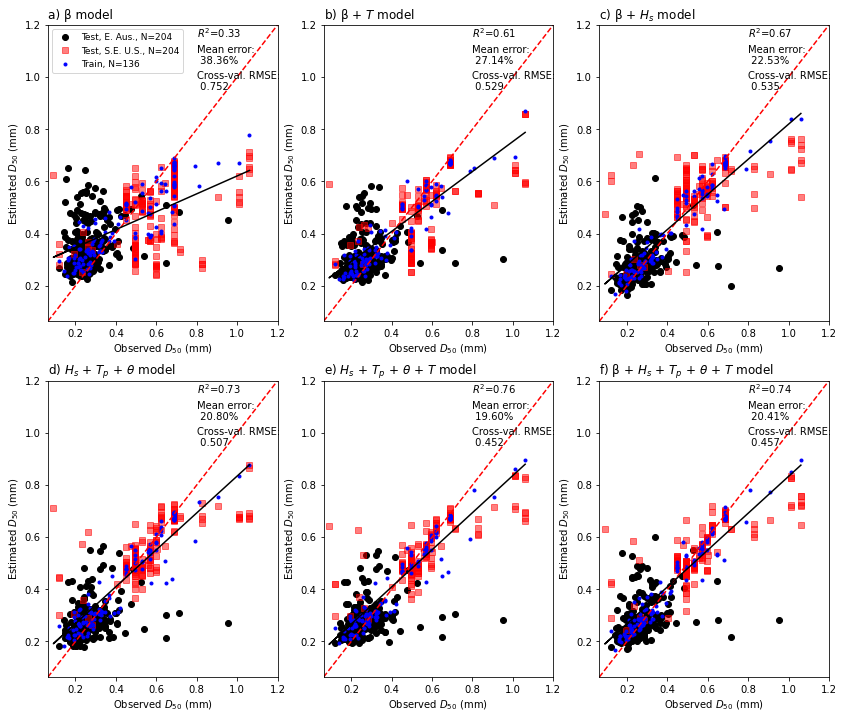

In [2185]:
plt.figure(figsize=(14,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(231)
ds_est = model7.predict(X_test7)
# plt.plot(y_test7, ds_est, 'ko')

code = tmp['code'][indices_test7]
plt.plot(y_test7[code==0], ds_est[code==0], 'ko', label='Test, E. Aus., N={}'.format(int(len(tmp)*(test_size)/2)))
plt.plot(y_test7[code==1], ds_est[code==1], 'rs',alpha=0.5, label='Test, S.E. U.S., N={}'.format(int(len(tmp)*(test_size)/2)))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'b.', label='Train, N={}'.format(int(len(tmp)*(1-test_size))))

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) β model", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')

pe = prc_err(y_test7, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model7out['rmse_mean_xval'])[:5]))

plt.legend(fontsize=9)

plt.subplot(232)
ds_est = model2.predict(X_test2)
# plt.plot(y_test2, ds_est, 'ko')

code = tmp['code'][indices_test2]
plt.plot(y_test2[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
plt.plot(y_test2[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("b) β + $T$ model", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')

pe = prc_err(y_test2, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model2out['rmse_mean_xval'])[:5]))

plt.subplot(233)
ds_est = model6.predict(X_test6)
# plt.plot(y_test6, ds_est, 'ko')

code = tmp['code'][indices_test6]
plt.plot(y_test6[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
plt.plot(y_test6[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"c) β + $H_s$ model", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:5]))
pe = prc_err(y_test6, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model6out['rmse_mean_xval'])[:5]))

plt.subplot(234)
ds_est = model3.predict(X_test3)
# plt.plot(y_test3, ds_est, 'ko')

code = tmp['code'][indices_test3]
plt.plot(y_test3[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
plt.plot(y_test3[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"d) $H_s$ + $T_p$ + $\theta$ model", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:5]))
pe = prc_err(y_test3, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model3out['rmse_mean_xval'])[:5]))

plt.subplot(235)
ds_est = model4.predict(X_test4)
# plt.plot(y_test4, ds_est, 'ko')

code = tmp['code'][indices_test4]
plt.plot(y_test4[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
plt.plot(y_test4[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:5]))
pe = prc_err(y_test4, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model4out['rmse_mean_xval'])[:5]))

plt.subplot(236)
ds_est = model1.predict(X_test1)
# plt.plot(y_test1, ds_est, 'ko')

code = tmp['code'][indices_test1]
plt.plot(y_test1[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
plt.plot(y_test1[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'b.', label='Train')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) β + $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

pe = prc_err(y_test1, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model1out['rmse_mean_xval'])[:5]))

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
# plt.legend()

plt.savefig('CGRASP_d50-6models_US-Oz-all.jpg', dpi=300, bbox_inches='tight')
# plt.close()

In [2186]:
# 204+204+136

### save model

In [2187]:
np.save('Combo_US_Oz_model1.npy', combo_model1out, allow_pickle=True)
np.save('Combo_US_Oz_model2.npy', combo_model2out, allow_pickle=True)
np.save('Combo_US_Oz_model3.npy', combo_model3out, allow_pickle=True)
np.save('Combo_US_Oz_model4.npy', combo_model4out, allow_pickle=True)
np.save('Combo_US_Oz_model6.npy', combo_model6out, allow_pickle=True)
np.save('Combo_US_Oz_model7.npy', combo_model7out, allow_pickle=True)

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation

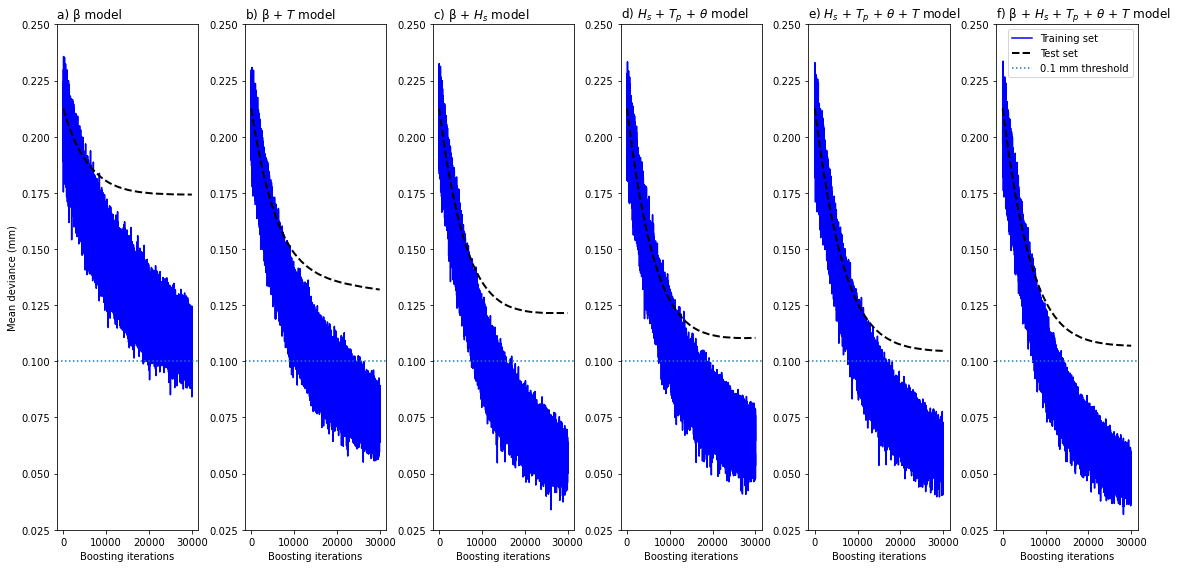

In [2188]:
fig=plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred7 in enumerate(model7.staged_predict(X_test7)):
    test_score[i] = model7.loss_(y_test7, y_pred7)
    
plt.subplot(1, 6, 1)
plt.title(r"a) β model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model7.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred2 in enumerate(model2.staged_predict(X_test2)):
    test_score[i] = model2.loss_(y_test2, y_pred2)
    
plt.subplot(1, 6, 2)
plt.title("b) β + $T$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model2.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred6 in enumerate(model6.staged_predict(X_test6)):
    test_score[i] = model6.loss_(y_test6, y_pred6)
    
plt.subplot(1, 6, 3)
plt.title(r"c) β + $H_s$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model6.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred3 in enumerate(model3.staged_predict(X_test3)):
    test_score[i] = model3.loss_(y_test3, y_pred3)
    
plt.subplot(1, 6, 4)
plt.title(r"d) $H_s$ + $T_p$ + $\theta$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model3.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred4 in enumerate(model4.staged_predict(X_test4)):
    test_score[i] = model4.loss_(y_test4, y_pred4)
    
plt.subplot(1, 6, 5)
plt.title(r"e) $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model4.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred1 in enumerate(model1.staged_predict(X_test1)):
    test_score[i] = model1.loss_(y_test1, y_pred1)
    
plt.subplot(1, 6, 6)
plt.title(r"f) β + $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model1.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

fig.tight_layout()
# plt.show()
plt.savefig('CGRASP_d50-6models-training_US-Oz-all.jpg', dpi=300, bbox_inches='tight')

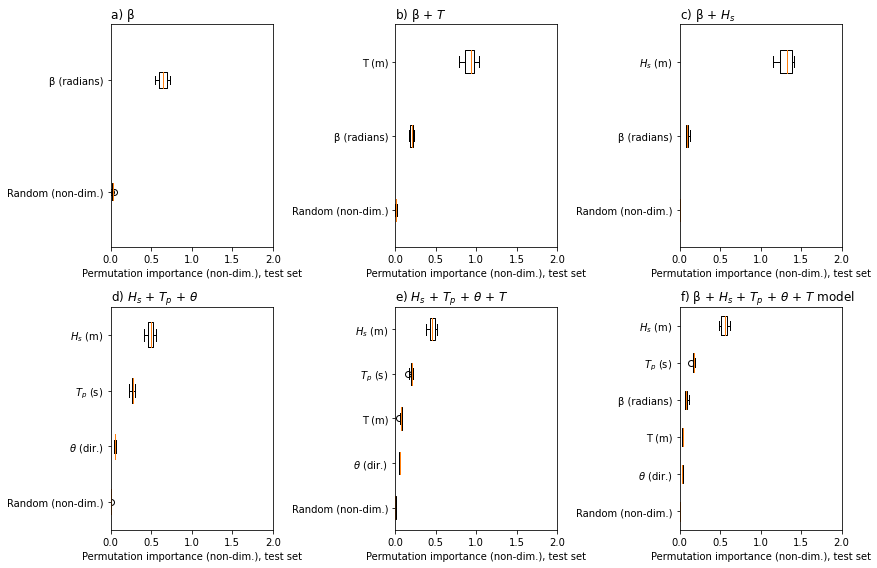

In [2189]:
fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
#############
plt.subplot(2,3, 1)
result = permutation_importance(
    model7, X_test7, y_test7, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(236)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names7)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"a) β ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 2)
result = permutation_importance(
    model2, X_test2, y_test2, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(232)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names2)[sorted_idx],
)

plt.xlim(0,2)
plt.title("b) β + $T$ ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 3)
result = permutation_importance(
    model6, X_test6, y_test6, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(235)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names6)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"c) β + $H_s$  ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 4)
result = permutation_importance(
    model3, X_test3, y_test3, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(233)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names3)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"d) $H_s$ + $T_p$ + $\theta$ ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 5)
result = permutation_importance(
    model4, X_test4, y_test4, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(234)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names4)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"e) $H_s$ + $T_p$ + $\theta$ + $T$ ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

# fig.tight_layout()

#############
plt.subplot(2,3, 6)
result = permutation_importance(
    model1, X_test1, y_test1, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(231)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names1)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"f) β + $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
fig.tight_layout()

plt.savefig('CGRASP_d50-6models-featimps_US-Oz-all.jpg', dpi=300, bbox_inches='tight')

### save dataset

In [2190]:
tmp.keys()

tmp = tmp[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 'code',
        'Hs_max', 'Hs_mean', 'Wdir_mean', 'Tp_mean']].copy()

In [2191]:
tmp.to_csv('combo_US_Oz_dataset.csv')

In [2192]:
tmpUS = tmp[tmp['code']==1]
tmpOz = tmp[tmp['code']==0]

In [2193]:
tmpUS.to_csv('combo_US_only_dataset.csv')

tmpOz.to_csv('combo_Oz_only_dataset.csv')

In [2321]:
combo_model1out = np.load('Combo_US_Oz_model1.npy', allow_pickle=True).item(0)
combo_model2out = np.load('Combo_US_Oz_model2.npy', allow_pickle=True).item(0)
combo_model3out = np.load('Combo_US_Oz_model3.npy', allow_pickle=True).item(0)
combo_model4out = np.load('Combo_US_Oz_model4.npy', allow_pickle=True).item(0)
combo_model6out = np.load('Combo_US_Oz_model6.npy', allow_pickle=True).item(0)
combo_model7out = np.load('Combo_US_Oz_model7.npy', allow_pickle=True).item(0)

In [2348]:
dfAllOz = gpd.read_file('dataset_Australia_all.geojson')
dfAllOz = dfAllOz[dfAllOz['d50']<2]

In [2349]:
randAllOz = np.random.randn(len(dfAllOz))

In [2350]:
X_predict_allOz = np.stack((dfAllOz['Hs_max'],dfAllOz['mstr'] ,dfAllOz['Tp_mean'],dfAllOz['Wdir_mean'], randAllOz))
index = ~np.isnan(X_predict_allOz).any(axis=0)
X_predict_allOz = X_predict_allOz[:,index]
X_predict_allOz[:,:].shape

(5, 1243)

In [2351]:
combo_model4out['model']

GradientBoostingRegressor(learning_rate=0.0001, max_depth=5,
                          min_samples_split=10, n_estimators=30000,
                          subsample=0.5)

In [2352]:
ds_est_allOz = combo_model4out['model'].predict(X_predict_allOz.T)

In [2353]:
yest = dfAllOz['d50'].copy().values
yest = yest[index]

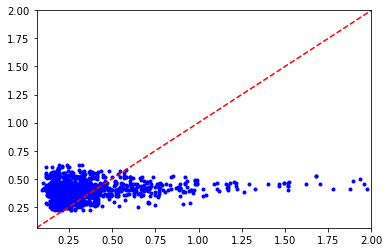

In [2356]:
plt.plot(yest,ds_est_allOz,'b.' )
plt.xlim(.063,2)
xl=plt.xlim()
plt.ylim(xl)
plt.plot(xl,xl,'r--')

### map plots

In [2194]:
X_predict_all = np.stack((tmp['Hs_max'],tmp['mstr'] ,tmp['Tp_mean'],tmp['Wdir_mean'], rand))
X_predict_all = X_predict_all[:,~np.isnan(X_predict_all).any(axis=0)]
X_predict_all[:,:].shape

(5, 544)

In [2195]:
# scaler = preprocessing.StandardScaler().fit(X_predict_all)
# X_predict_all = scaler.transform(X_predict_all)

In [2196]:
# X_predict_all[:,:].shape

In [2238]:
tmp = tmp.assign(rand=rand)

test,train,test_indices,train_indices = train_test_split(
    tmp, indices, test_size=1-test_size, random_state=2022
)

Xtest = np.stack((test['Hs_max'],test['mstr'] ,test['Tp_mean'],test['Wdir_mean'],test['rand']))

ds_est_test = combo_model4out['model'].predict(Xtest.T)

Xtrain = np.stack((train['Hs_max'],train['mstr'] ,train['Tp_mean'],train['Wdir_mean'],train['rand']))

ds_est_train = combo_model4out['model'].predict(Xtrain.T)

In [2239]:
ds_est_all = combo_model4out['model'].predict(X_predict_all.T)

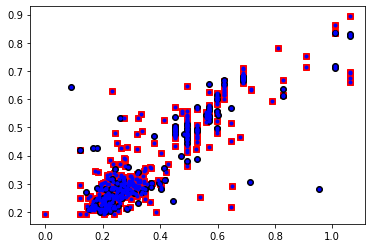

In [2240]:
plt.plot(tmp['d50'][test_indices],ds_est_test,'rs' )
plt.plot(tmp['d50'][train_indices],ds_est_train,'ko' )
plt.plot(tmp['d50'],ds_est_all,'b.' )

In [2241]:
large_over = np.where(100*((tmp['d50'][test_indices]-ds_est_test)/tmp['d50'][test_indices])>20)[0]
large_under = np.where(100*((tmp['d50'][test_indices]-ds_est_test)/tmp['d50'][test_indices])<-20)[0]
print(len(large_over))
print(len(large_under))

100*((len(large_over) + len(large_under))/len(tmp['d50'][test_indices]))

27
82


26.715686274509803

In [2242]:
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

In [2243]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')

In [2252]:
varss = ['beach_slope_average', 'd50', 'Tp_mean', 'mstr', 'Hs_max']
vmins = [0.01,.1,4,1,1]
vmaxs = [.1,1.1,12,2,8]

labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 'Peak Wave Period (s)', 
          'Mean Spring Tidal Range (m)','Max Significant Wave Height (m)']

titles = ['a)', '', 'b)', 'c)', 'd)']

figs = ['SEUS_slope-map.jpg', 
        'SEUS_d50observed-map.jpg', 
        'SEUS_tp-map.jpg', 
        'SEUS_mstr-map.jpg', 
        'SEUS_hs-map.jpg']

In [2253]:
# var = varss[1]
# outfile = figs[1]
# vmin = vmins[1]
# vmax = vmaxs[1]
# label = labels[1]
# title = titles[1]

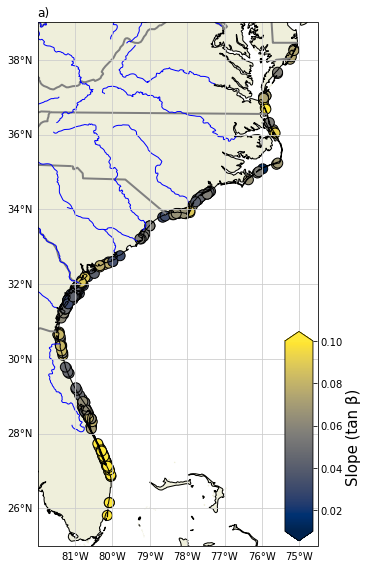

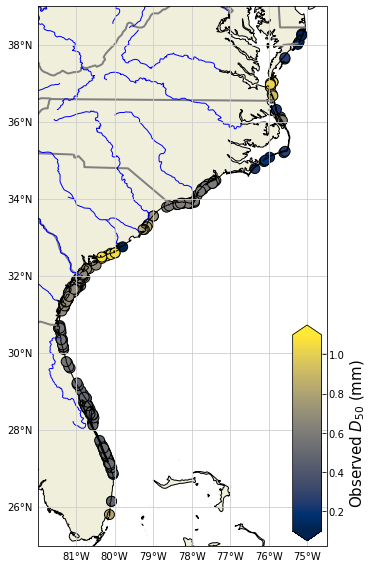

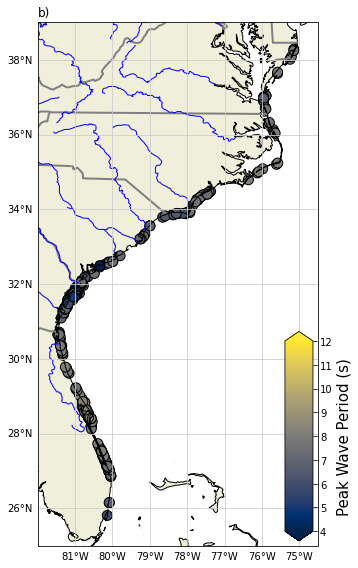

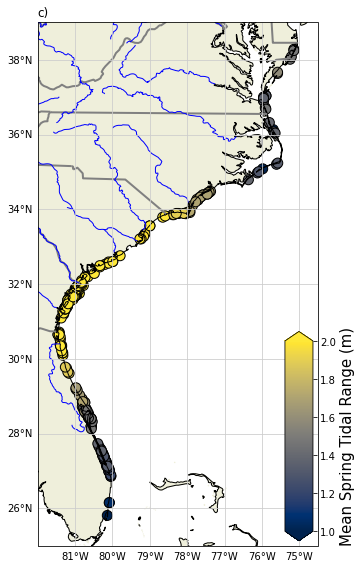

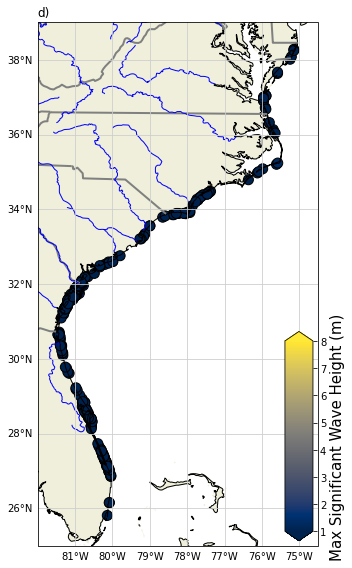

In [2254]:
for var,outfile,vmin,vmax,label,title in zip(*[varss,figs,vmins,vmaxs,labels, titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(16,8))
    ax = plt.axes(projection=crs)
    ax.set_extent([-82, -74.5, 25, 39], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(tmp['longitude'],tmp['latitude'],100,tmp[var], cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    plt.title(title, loc='left')
    # plt.legend(loc=4, fontsize=12)

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=4) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)

    plt.savefig(outfile, dpi=300, bbox_inches='tight')

In [2089]:
# np.min(df['latitude'][df['code']==0])

In [2090]:
# np.max(df['latitude'][df['code']==0])

In [2091]:
# np.min(df['longitude'][df['code']==0])

In [2092]:
# np.max(df['longitude'][df['code']==0])

In [2255]:
figs = ['EAUS_slope-map.jpg', 
        'EAUS_d50observed-map.jpg', 
        'EAUS_tp-map.jpg', 
        'EAUS_mstr-map.jpg', 
        'EAUS_hs-map.jpg']

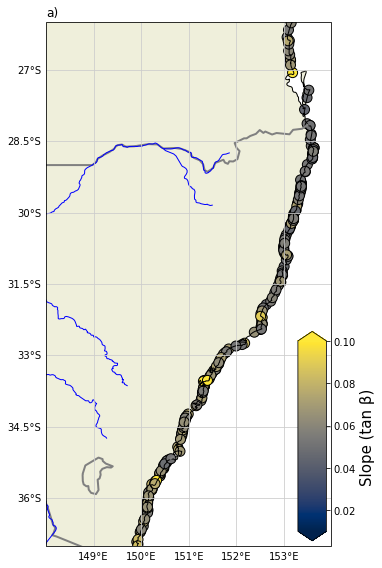

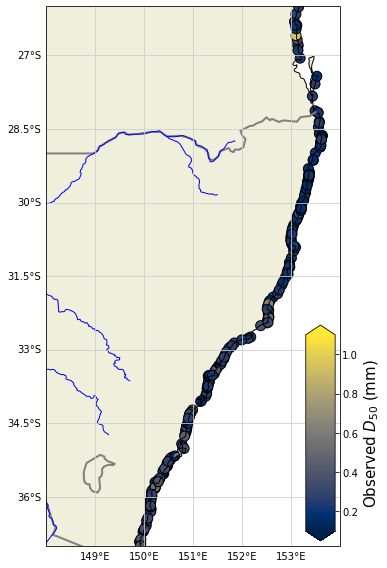

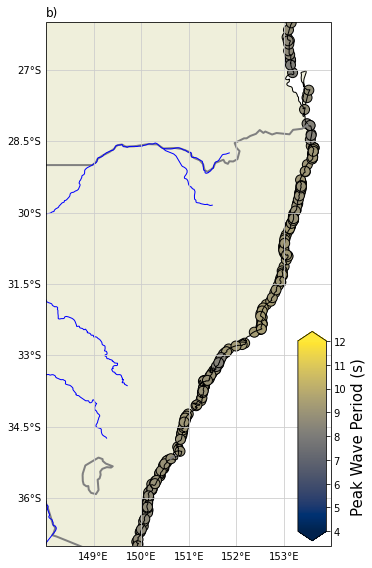

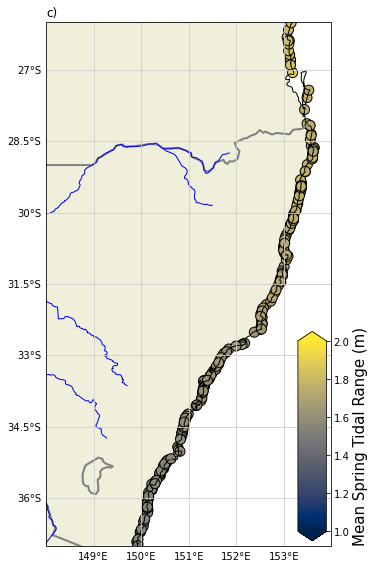

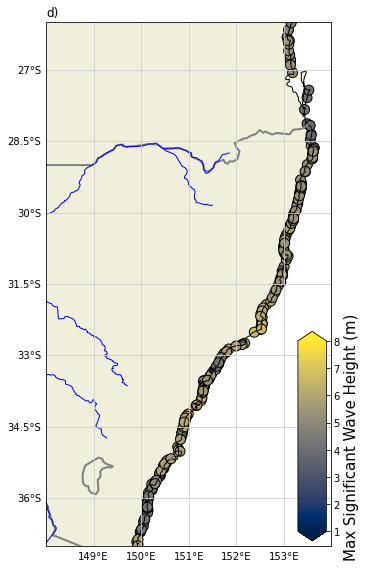

In [2256]:
for var,outfile,vmin,vmax,label,title in zip(*[varss,figs,vmins,vmaxs,labels, titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(16,8))
    ax = plt.axes(projection=crs)
    ax.set_extent([148, 154,-37, -26], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(tmp['longitude'],tmp['latitude'],100,tmp[var], cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    plt.title(title, loc='left')
    # plt.legend(loc=4, fontsize=12)

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=4) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)

    plt.savefig(outfile, dpi=300, bbox_inches='tight')

In [2114]:
# test,train = train_test_split(
#     tmp, test_size=test_size, random_state=2022
# )
# Xtest = np.stack((test['Hs_max'],test['mstr'] ,test['Tp_mean'],test['Wdir_mean'], test['rand']))

# scaler = preprocessing.StandardScaler().fit(Xtest)
# Xtest = scaler.transform(Xtest)

# ds_est_test = combo_model4out['model'].predict(Xtest.T)

# Xtrain = np.stack((train['Hs_max'],train['mstr'] ,train['Tp_mean'],train['Wdir_mean'], train['rand']))

# scaler = preprocessing.StandardScaler().fit(Xtrain)
# Xtrain = scaler.transform(Xtrain)

# ds_est_train = combo_model4out['model'].predict(Xtrain.T)

In [2244]:
len(train['longitude'])

136

In [2245]:
len(d)

408

In [2257]:
a = 100*((tmp['d50'][train_indices]-ds_est_train)/tmp['d50'][train_indices])
b = 100*((tmp['d50'][test_indices]-ds_est_test)/tmp['d50'][test_indices])
c = 100*((tmp['d50']-ds_est_all)/tmp['d50'])
d = ds_est_train
e = ds_est_test
f = np.hstack((ds_est_train,ds_est_test))
g = np.hstack((tmp['d50'][train_indices],tmp['d50'][test_indices]))
varss = [a,b,c,d,e,f,g]

xs = [train['longitude'],test['longitude'],tmp['longitude'],
      train['longitude'],test['longitude'],tmp['longitude'],tmp['longitude']]
ys = [train['latitude'],test['latitude'],tmp['latitude'],
      train['latitude'],test['latitude'],tmp['latitude'],tmp['latitude']]

vmins = [-20,-20,-20,.1,.1,.1,.1]
vmaxs = [20,20,20,1.1,1.1,1.1,1.1]

labels = ['Observed vs estimated $D_{50}$ (%)', 
          'Observed vs estimated $D_{50}$ (%)',
          'Observed vs estimated $D_{50}$ (%)',
          'Estimated $D_{50}$ (mm)',
          'Estimated $D_{50}$ (mm)',
          'Estimated $D_{50}$ (mm)',
         ]

figs = ['SEUS_d50-slope-tide-predict-map-diff-train-set.jpg', 
        'SEUS_d50-slope-tide-predict-map-diff-test-set.jpg',
        'SEUS_d50-slope-tide-predict-map-diff.jpg',
        'SEUS_d50-slope-tide-predict-map_train_set.jpg',
        'SEUS_d50-slope-tide-predict-map_test_set.jpg',
        'SEUS_d50-slope-tide-predict-map.jpg'       
       ]

titles=['c)','c)','c)','c)','b)','b)','a)']

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


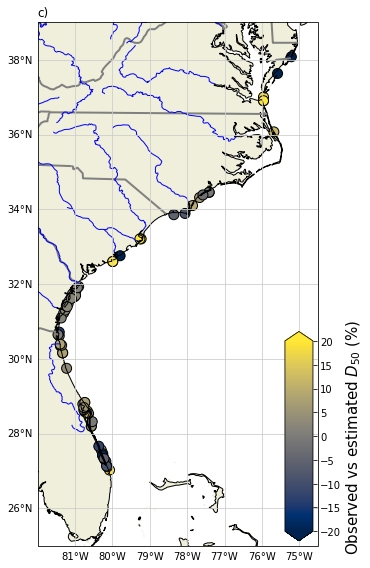

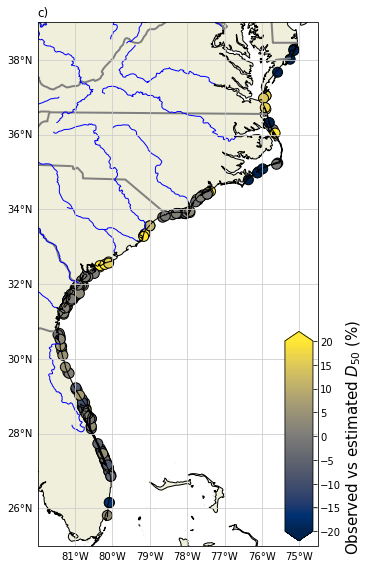

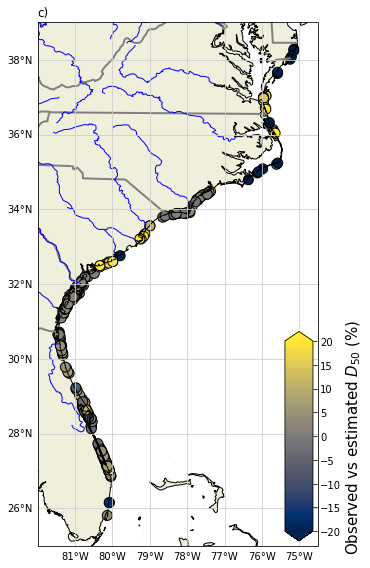

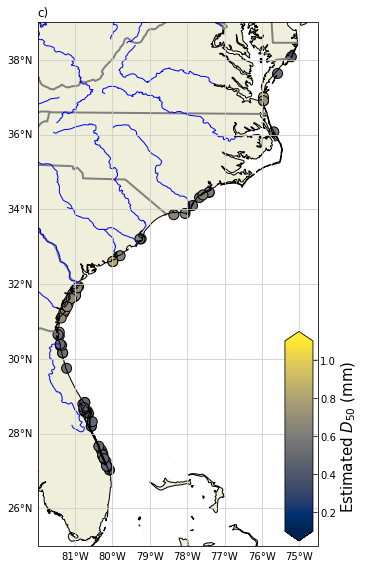

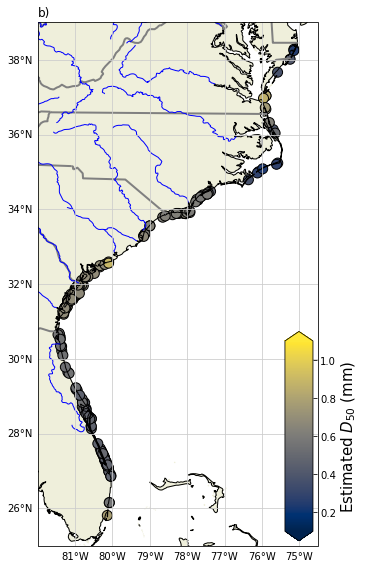

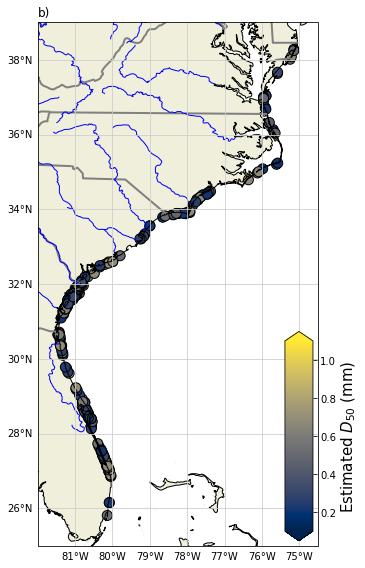

In [2258]:
for var,outfile,vmin,vmax,label,x,y,title in zip(*[varss,figs,vmins,vmaxs,labels,xs,ys,titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(16,8))
    ax = plt.axes(projection=crs)
    ax.set_extent([-82, -74.5, 25, 39], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(x,y,100,var, cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    # plt.legend(loc=4, fontsize=12)
#     cb=plt.colorbar(extend='both', shrink=0.5)
#     cb.set_label(label, fontsize=15)
    plt.title(title, loc='left')

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=4) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)
    
    plt.savefig(outfile, dpi=300, bbox_inches='tight')


In [2259]:
figs = ['EAUS_d50-slope-tide-predict-map-diff-train-set.jpg', 
        'EAUS_d50-slope-tide-predict-map-diff-test-set.jpg',
        'EAUS_d50-slope-tide-predict-map-diff.jpg',
        'EAUS_d50-slope-tide-predict-map_train_set.jpg',
        'EAUS_d50-slope-tide-predict-map_test_set.jpg',
        'EAUS_d50-slope-tide-predict-map.jpg'       
       ]

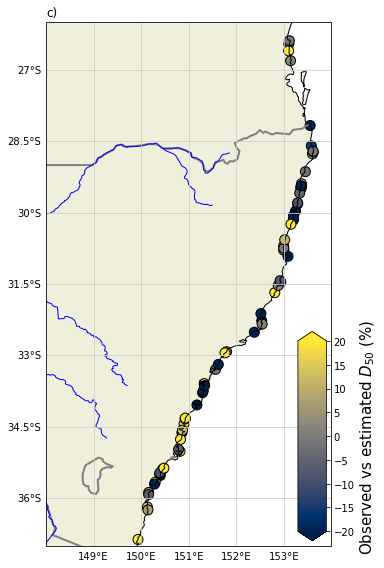

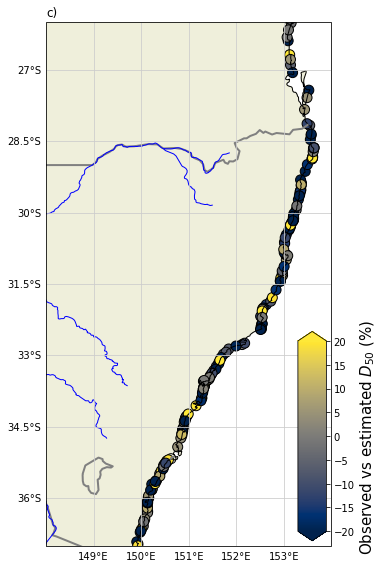

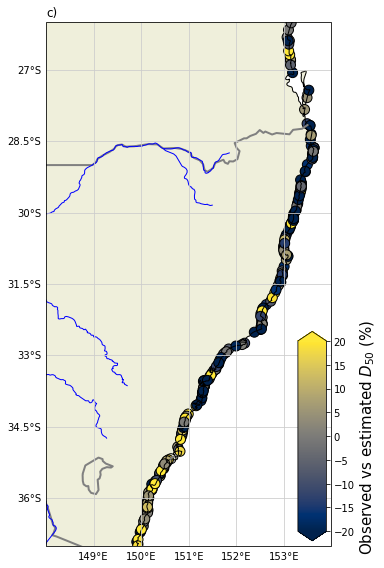

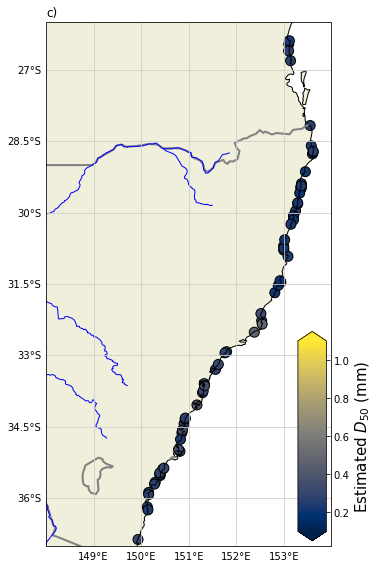

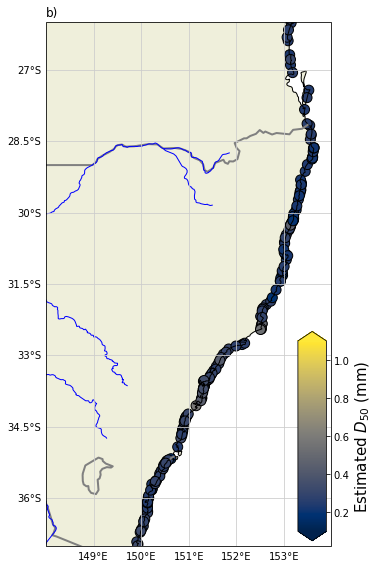

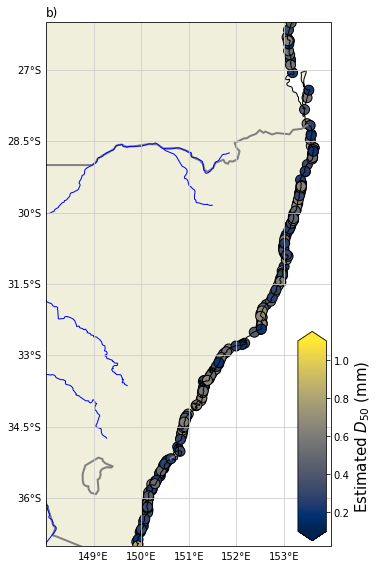

In [2260]:
for var,outfile,vmin,vmax,label,x,y,title in zip(*[varss,figs,vmins,vmaxs,labels,xs,ys,titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(16,8))
    ax = plt.axes(projection=crs)
    ax.set_extent([148, 154,-37, -26], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(x,y,100,var, cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    # plt.legend(loc=4, fontsize=12)
#     cb=plt.colorbar(extend='both', shrink=0.5)
#     cb.set_label(label, fontsize=15)
    plt.title(title, loc='left')

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=4) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)
    
    plt.savefig(outfile, dpi=300, bbox_inches='tight')


### US only

In [2261]:
yscaler = preprocessing.StandardScaler().fit(tmpUS['d50'].values.reshape(-1, 1))
y = yscaler.transform(tmpUS['d50'].values.reshape(-1, 1))

indices = np.arange(len(y))

In [2262]:
# params = {
#     "n_estimators": 30000,
#     "max_depth": 5, #4,
#     "min_samples_split": 10, #10,
#     "learning_rate": 0.0001, #1, #0.01,
#     "loss": "squared_error",
#     "subsample": 0.5,
# }

params = {
    "n_estimators": 30000,
    "max_depth": 4, 
    "min_samples_split": 10, 
    "learning_rate": 0.0001, 
    "loss": "squared_error",
    "subsample": 0.8,
}

test_size = 0.75

In [2263]:
randUS = np.random.randn(len(tmpUS))
np.save('US_rand.npy', randUS, allow_pickle=True)

In [2264]:
feature_names1 = ['β (radians)',r'$H_s$ (m)', 'T (m)',r'$T_p$ (s)', r'$\theta$ (dir.)','Random (non-dim.)'] 
X = np.stack((tmpUS['beach_slope_average'],tmpUS['Hs_max'],tmpUS['mstr'] ,tmpUS['Tp_mean'],tmpUS['Wdir_mean'],  randUS)) 
X.shape

X_train1, X_test1, y_train1, y_test1, indices_train1, indices_test1 = train_test_split(
    X.T, y.ravel() , indices, test_size=test_size, random_state=2022, 
)

#unscale y - we balanced it to sample equally among grain size bins
y_test1 = yscaler.inverse_transform(y_test1.reshape(-1, 1)).squeeze()
y_train1 = yscaler.inverse_transform(y_train1.reshape(-1, 1)).squeeze()

print(y_test1.max())
print(y_train1.max())

#scale x
# scaler = preprocessing.StandardScaler().fit(X_train1)
# X_train1 = scaler.transform(X_train1)
# X_test1 = scaler.transform(X_test1)

# model1 = xgb.XGBRFRegressor(**xparams)
model1 = ensemble.GradientBoostingRegressor(**params)
# model1 = ensemble.HistGradientBoostingRegressor()#**params)
model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0174


In [2265]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.512 (0.154)


In [2266]:
US_model1out = {}
US_model1out['feature_names'] = feature_names1
US_model1out['Xtest'] = X_test1
US_model1out['Xtrain'] = X_train1
US_model1out['ytest'] = y_test1
US_model1out['ytrain'] = y_train1
US_model1out['model'] = model1
US_model1out['mse'] = mse1
US_model1out['rmse_mean_xval'] = scores.mean()
US_model1out['rmse_std_xval'] = scores.std()

In [2267]:
feature_names2 = [r'β (radians)','T (m)', 'Random (non-dim.)']
X = np.stack((tmpUS['beach_slope_average'],tmpUS['mstr'], randUS))
X.shape

X_train2, X_test2, y_train2, y_test2, indices_train2, indices_test2 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test2 = yscaler.inverse_transform(y_test2.reshape(-1, 1)).squeeze()
y_train2 = yscaler.inverse_transform(y_train2.reshape(-1, 1)).squeeze()

print(y_test2.max())
print(y_train2.max())

# scaler = preprocessing.StandardScaler().fit(X_train2)
# X_train2 = scaler.transform(X_train2)
# X_test2 = scaler.transform(X_test2)

# model2 = svm.SVR()
# model2 = xgb.XGBRFRegressor(**xparams)
model2 = ensemble.GradientBoostingRegressor(**params)
# model2 = ensemble.HistGradientBoostingRegressor()#**params)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0088


In [2268]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.480 (0.126)


In [2269]:
US_model2out = {}
US_model2out['feature_names'] = feature_names2
US_model2out['Xtest'] = X_test2
US_model2out['Xtrain'] = X_train2
US_model2out['ytest'] = y_test2
US_model2out['ytrain'] = y_train2
US_model2out['model'] = model2
US_model2out['mse'] = mse2
US_model2out['rmse_mean_xval'] = scores.mean()
US_model2out['rmse_std_xval'] = scores.std()

In [2270]:
feature_names3 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)', 'Random (non-dim.)'] #
X = np.stack((tmpUS['Hs_max'],tmpUS['Tp_mean'],tmpUS['Wdir_mean'], randUS)) 
X.shape

X_train3, X_test3, y_train3, y_test3, indices_train3, indices_test3 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test3 = yscaler.inverse_transform(y_test3.reshape(-1, 1)).squeeze()
y_train3 = yscaler.inverse_transform(y_train3.reshape(-1, 1)).squeeze()

print(y_test3.max())
print(y_train3.max())

# scaler = preprocessing.StandardScaler().fit(X_train3)
# X_train3 = scaler.transform(X_train3)
# X_test3 = scaler.transform(X_test3)

# model3 = xgb.XGBRFRegressor(**xparams)
# model3 = ensemble.HistGradientBoostingRegressor()#**params)
model3 = ensemble.GradientBoostingRegressor(**params)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0200


In [2271]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.672 (0.180)


In [2272]:
US_model3out = {}
US_model3out['feature_names'] = feature_names3
US_model3out['Xtest'] = X_test3
US_model3out['Xtrain'] = X_train3
US_model3out['ytest'] = y_test3
US_model3out['ytrain'] = y_train3
US_model3out['model'] = model3
US_model3out['mse'] = mse3
US_model3out['rmse_mean_xval'] = scores.mean()
US_model3out['rmse_std_xval'] = scores.std()

In [2273]:
feature_names4 = [r'$H_s$ (m)', 'T (m)',r'$T_p$ (s)', r'$\theta$ (dir.)', 'Random (non-dim.)'] #
X = np.stack((tmpUS['Hs_max'],tmpUS['mstr'] ,tmpUS['Tp_mean'],tmpUS['Wdir_mean'], randUS)) 
X.shape

X_train4, X_test4, y_train4, y_test4, indices_train4, indices_test4 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test4 = yscaler.inverse_transform(y_test4.reshape(-1, 1)).squeeze()
y_train4 = yscaler.inverse_transform(y_train4.reshape(-1, 1)).squeeze()

print(y_test4.max())
print(y_train4.max())

# scaler = preprocessing.StandardScaler().fit(X_train4)
# X_train4 = scaler.transform(X_train4)
# X_test4 = scaler.transform(X_test4)

# model4 = xgb.XGBRFRegressor(**params)
model4 = ensemble.GradientBoostingRegressor(**params)
# model4 = ensemble.HistGradientBoostingRegressor()#**params)
model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0175


In [2274]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.521 (0.150)


In [2275]:
US_model4out = {}
US_model4out['feature_names'] = feature_names4
US_model4out['Xtest'] = X_test4
US_model4out['Xtrain'] = X_train4
US_model4out['ytest'] = y_test4
US_model4out['ytrain'] = y_train4
US_model4out['model'] = model4
US_model4out['mse'] = mse4
US_model4out['rmse_mean_xval'] = scores.mean()
US_model4out['rmse_std_xval'] = scores.std()

In [2276]:
feature_names6 = [r'β (radians)', r'$H_s$ (m)', 'Random (non-dim.)']
X = np.stack((tmpUS['beach_slope_average'], tmpUS['Hs_max'], randUS))
X.shape

X_train6, X_test6, y_train6, y_test6, indices_train6, indices_test6 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test6 = yscaler.inverse_transform(y_test6.reshape(-1, 1)).squeeze()
y_train6 = yscaler.inverse_transform(y_train6.reshape(-1, 1)).squeeze()

print(y_test6.max())
print(y_train6.max())

# scaler = preprocessing.StandardScaler().fit(X_train6)
# X_train6 = scaler.transform(X_train6)
# X_test6 = scaler.transform(X_test6)

# model6 = xgb.XGBRFRegressor(**params)
# model6 = ensemble.HistGradientBoostingRegressor()#**params)
model6 = ensemble.GradientBoostingRegressor(**params)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6, model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0169


In [2277]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.740 (0.148)


In [2278]:
US_model6out = {}
US_model6out['feature_names'] = feature_names6
US_model6out['Xtest'] = X_test6
US_model6out['Xtrain'] = X_train6
US_model6out['ytest'] = y_test6
US_model6out['ytrain'] = y_train6
US_model6out['model'] = model6
US_model6out['mse'] = mse6
US_model6out['rmse_mean_xval'] = scores.mean()
US_model6out['rmse_std_xval'] = scores.std()

In [2279]:
feature_names7 = [r'β (radians)', 'Random (non-dim.)']
X = np.stack((tmpUS['beach_slope_average'], randUS))
X.shape

X_train7, X_test7, y_train7, y_test7, indices_train7, indices_test7 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test7 = yscaler.inverse_transform(y_test7.reshape(-1, 1)).squeeze()
y_train7 = yscaler.inverse_transform(y_train7.reshape(-1, 1)).squeeze()

print(y_test7.max())
print(y_train7.max())

# scaler = preprocessing.StandardScaler().fit(X_train7)
# X_train7 = scaler.transform(X_train7)
# X_test7 = scaler.transform(X_test7)

# model7 = xgb.XGBRFRegressor(**params)
# model7 = ensemble.HistGradientBoostingRegressor()#**params)
model7 = ensemble.GradientBoostingRegressor(**params)
model7.fit(X_train7, y_train7)

mse7 = mean_squared_error(y_test7, model7.predict(X_test7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse7))

1.06082628750927
1.06082628750927
The mean squared error (MSE) on test set: 0.0196


In [2280]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model7, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.781 (0.155)


In [2281]:
US_model7out = {}
US_model7out['feature_names'] = feature_names7
US_model7out['Xtest'] = X_test7
US_model7out['Xtrain'] = X_train7
US_model7out['ytest'] = y_test7
US_model7out['ytrain'] = y_train7
US_model7out['model'] = model7
US_model7out['mse'] = mse7
US_model7out['rmse_mean_xval'] = scores.mean()
US_model7out['rmse_std_xval'] = scores.std()

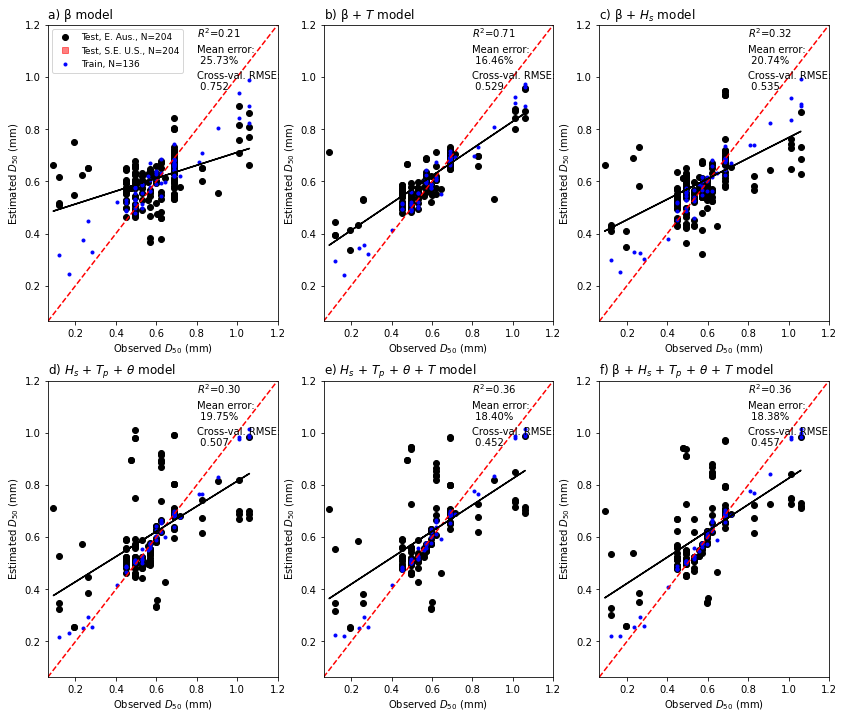

In [2282]:
plt.figure(figsize=(14,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(231)
ds_est = model7.predict(X_test7)
# plt.plot(y_test7, ds_est, 'ko')

code = tmp['code'][indices_test7]
plt.plot(y_test7[code==0], ds_est[code==0], 'ko', label='Test, E. Aus., N={}'.format(int(len(tmp)*(test_size)/2)))
plt.plot(y_test7[code==1], ds_est[code==1], 'rs',alpha=0.5, label='Test, S.E. U.S., N={}'.format(int(len(tmp)*(test_size)/2)))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'b.', label='Train, N={}'.format(int(len(tmp)*(1-test_size))))

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) β model", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')

pe = prc_err(y_test7, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model7out['rmse_mean_xval'])[:5]))

plt.legend(fontsize=9)

plt.subplot(232)
ds_est = model2.predict(X_test2)
# plt.plot(y_test2, ds_est, 'ko')

code = tmp['code'][indices_test2]
plt.plot(y_test2[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
plt.plot(y_test2[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("b) β + $T$ model", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')

pe = prc_err(y_test2, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model2out['rmse_mean_xval'])[:5]))

plt.subplot(233)
ds_est = model6.predict(X_test6)
# plt.plot(y_test6, ds_est, 'ko')

code = tmp['code'][indices_test6]
plt.plot(y_test6[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
plt.plot(y_test6[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"c) β + $H_s$ model", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:5]))
pe = prc_err(y_test6, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model6out['rmse_mean_xval'])[:5]))

plt.subplot(234)
ds_est = model3.predict(X_test3)
# plt.plot(y_test3, ds_est, 'ko')

code = tmp['code'][indices_test3]
plt.plot(y_test3[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
plt.plot(y_test3[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"d) $H_s$ + $T_p$ + $\theta$ model", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:5]))
pe = prc_err(y_test3, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model3out['rmse_mean_xval'])[:5]))

plt.subplot(235)
ds_est = model4.predict(X_test4)
# plt.plot(y_test4, ds_est, 'ko')

code = tmp['code'][indices_test4]
plt.plot(y_test4[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
plt.plot(y_test4[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:5]))
pe = prc_err(y_test4, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model4out['rmse_mean_xval'])[:5]))

plt.subplot(236)
ds_est = model1.predict(X_test1)
# plt.plot(y_test1, ds_est, 'ko')

code = tmp['code'][indices_test1]
plt.plot(y_test1[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
plt.plot(y_test1[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'b.', label='Train')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) β + $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

pe = prc_err(y_test1, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model1out['rmse_mean_xval'])[:5]))

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
# plt.legend()


plt.savefig('CGRASP_d50-6models_US-all.jpg', dpi=300, bbox_inches='tight')
# plt.close()

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation

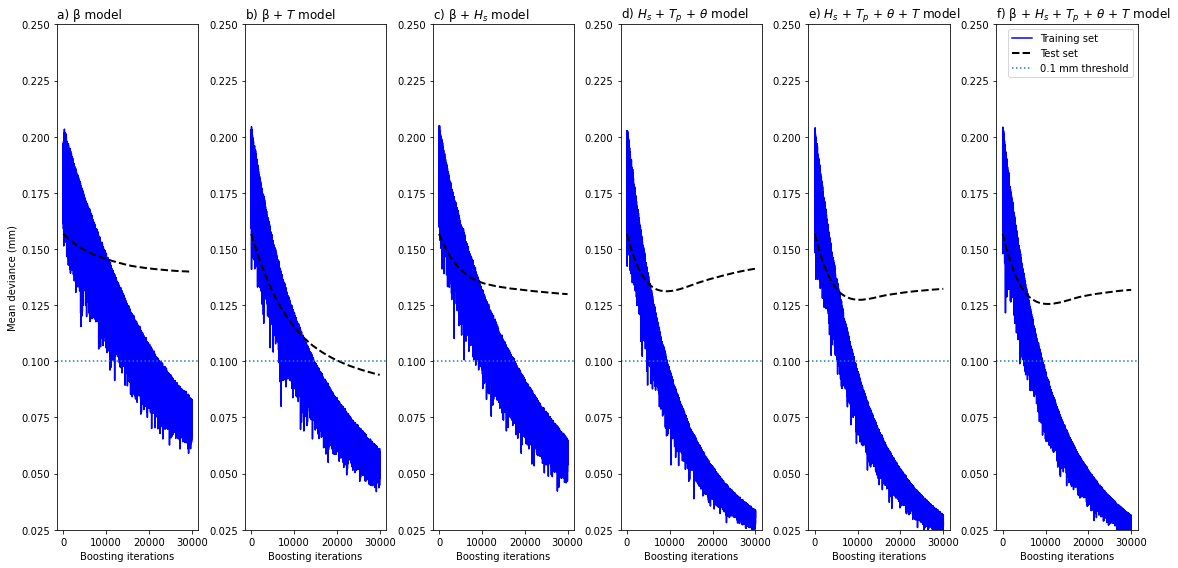

In [2283]:
fig=plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred7 in enumerate(model7.staged_predict(X_test7)):
    test_score[i] = model7.loss_(y_test7, y_pred7)
    
plt.subplot(1, 6, 1)
plt.title(r"a) β model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model7.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred2 in enumerate(model2.staged_predict(X_test2)):
    test_score[i] = model2.loss_(y_test2, y_pred2)
    
plt.subplot(1, 6, 2)
plt.title("b) β + $T$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model2.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred6 in enumerate(model6.staged_predict(X_test6)):
    test_score[i] = model6.loss_(y_test6, y_pred6)
    
plt.subplot(1, 6, 3)
plt.title(r"c) β + $H_s$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model6.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred3 in enumerate(model3.staged_predict(X_test3)):
    test_score[i] = model3.loss_(y_test3, y_pred3)
    
plt.subplot(1, 6, 4)
plt.title(r"d) $H_s$ + $T_p$ + $\theta$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model3.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred4 in enumerate(model4.staged_predict(X_test4)):
    test_score[i] = model4.loss_(y_test4, y_pred4)
    
plt.subplot(1, 6, 5)
plt.title(r"e) $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model4.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred1 in enumerate(model1.staged_predict(X_test1)):
    test_score[i] = model1.loss_(y_test1, y_pred1)
    
plt.subplot(1, 6, 6)
plt.title(r"f) β + $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model1.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

fig.tight_layout()
# plt.show()
plt.savefig('CGRASP_d50-6models-training_US-all.jpg', dpi=300, bbox_inches='tight')

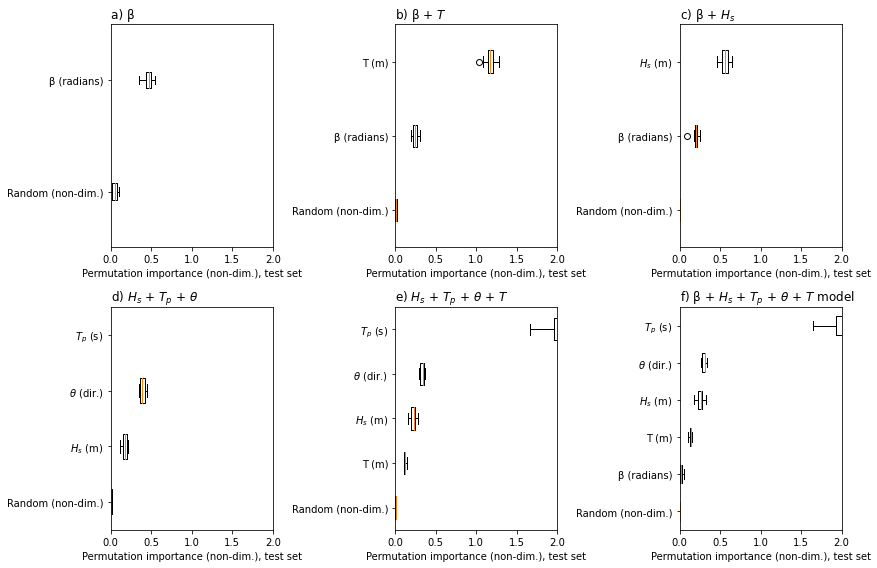

In [2284]:
fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
#############
plt.subplot(2,3, 1)
result = permutation_importance(
    model7, X_test7, y_test7, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(236)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names7)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"a) β ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 2)
result = permutation_importance(
    model2, X_test2, y_test2, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(232)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names2)[sorted_idx],
)

plt.xlim(0,2)
plt.title("b) β + $T$ ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 3)
result = permutation_importance(
    model6, X_test6, y_test6, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(235)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names6)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"c) β + $H_s$  ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 4)
result = permutation_importance(
    model3, X_test3, y_test3, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(233)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names3)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"d) $H_s$ + $T_p$ + $\theta$ ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 5)
result = permutation_importance(
    model4, X_test4, y_test4, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(234)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names4)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"e) $H_s$ + $T_p$ + $\theta$ + $T$ ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

# fig.tight_layout()

#############
plt.subplot(2,3, 6)
result = permutation_importance(
    model1, X_test1, y_test1, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(231)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names1)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"f) β + $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
fig.tight_layout()

plt.savefig('CGRASP_d50-6models-featimps_US-all.jpg', dpi=300, bbox_inches='tight')


In [2285]:
np.save('US_model1.npy', US_model1out, allow_pickle=True)
np.save('US_model2.npy', US_model2out, allow_pickle=True)
np.save('US_model3.npy', US_model3out, allow_pickle=True)
np.save('US_model4.npy', US_model4out, allow_pickle=True)
np.save('US_model6.npy', US_model6out, allow_pickle=True)
np.save('US_model7.npy', US_model7out, allow_pickle=True)


### Oz only

In [2286]:
yscaler = preprocessing.StandardScaler().fit(tmpOz['d50'].values.reshape(-1, 1))
y = yscaler.transform(tmpOz['d50'].values.reshape(-1, 1))

indices = np.arange(len(y))

In [2287]:
params = {
    "n_estimators": 30000,
    "max_depth": 5, #4,
    "min_samples_split": 10, #10,
    "learning_rate": 0.0001, #1, #0.01,
    "loss": "squared_error",
    "subsample": 0.5,
}

# params = {
#     "n_estimators": 50000,
#     "max_depth": 5, 
#     "min_samples_split": 5, #10,
#     "learning_rate": 0.00001, #1, #0.01,
#     "loss": "squared_error",
#     "subsample": 0.5,
# }

# params = {
#     "n_estimators": 40000,
#     "max_depth": 5, 
#     "min_samples_split": 10, #10,
#     "learning_rate": 0.00005, #1, #0.01,
#     "loss": "squared_error",
#     "subsample": 0.4,
# }


test_size = 0.75

In [2288]:
randOz = np.random.randn(len(tmpOz))
np.save('Oz_rand.npy', randOz, allow_pickle=True)

In [2289]:
feature_names1 = ['β (radians)',r'$H_s$ (m)', 'T (m)',r'$T_p$ (s)', r'$\theta$ (dir.)','Random (non-dim.)'] 
X = np.stack((tmpOz['beach_slope_average'],tmpOz['Hs_max'],tmpOz['mstr'] ,tmpOz['Tp_mean'],tmpOz['Wdir_mean'],  randOz)) 
X.shape

X_train1, X_test1, y_train1, y_test1, indices_train1, indices_test1 = train_test_split(
    X.T, y.ravel() , indices, test_size=test_size, random_state=42, 
)

#unscale y - we balanced it to sample equally among grain size bins
y_test1 = yscaler.inverse_transform(y_test1.reshape(-1, 1)).squeeze()
y_train1 = yscaler.inverse_transform(y_train1.reshape(-1, 1)).squeeze()

print(y_test1.max())
print(y_train1.max())

#scale x
# scaler = preprocessing.StandardScaler().fit(X_train1)
# X_train1 = scaler.transform(X_train1)
# X_test1 = scaler.transform(X_test1)

# model1 = xgb.XGBRFRegressor(**xparams)
model1 = ensemble.GradientBoostingRegressor(**params)
# model1 = ensemble.HistGradientBoostingRegressor()#**params)
model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

0.79
0.9526399999999999
The mean squared error (MSE) on test set: 0.0207


In [2290]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model1, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.984 (0.252)


In [2291]:
Aus_model1out = {}
Aus_model1out['feature_names'] = feature_names1
Aus_model1out['Xtest'] = X_test1
Aus_model1out['Xtrain'] = X_train1
Aus_model1out['ytest'] = y_test1
Aus_model1out['ytrain'] = y_train1
Aus_model1out['model'] = model1
Aus_model1out['mse'] = mse1
Aus_model1out['rmse_mean_xval'] = scores.mean()
Aus_model1out['rmse_std_xval'] = scores.std()

In [2292]:
feature_names2 = [r'β (radians)','T (m)', 'Random (non-dim.)']
X = np.stack((tmpOz['beach_slope_average'],tmpOz['mstr'], randOz))
X.shape

X_train2, X_test2, y_train2, y_test2, indices_train2, indices_test2 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=42
)

#unscale y - we balanced it to sample equally among grain size bins
y_test2 = yscaler.inverse_transform(y_test2.reshape(-1, 1)).squeeze()
y_train2 = yscaler.inverse_transform(y_train2.reshape(-1, 1)).squeeze()

print(y_test2.max())
print(y_train2.max())

# scaler = preprocessing.StandardScaler().fit(X_train2)
# X_train2 = scaler.transform(X_train2)
# X_test2 = scaler.transform(X_test2)

# model2 = svm.SVR()
# model2 = xgb.XGBRFRegressor(**xparams)
model2 = ensemble.GradientBoostingRegressor(**params)
# model2 = ensemble.HistGradientBoostingRegressor()#**params)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

0.79
0.9526399999999999
The mean squared error (MSE) on test set: 0.0211


In [2293]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model2, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 1.003 (0.255)


In [2294]:
Aus_model2out = {}
Aus_model2out['feature_names'] = feature_names2
Aus_model2out['Xtest'] = X_test2
Aus_model2out['Xtrain'] = X_train2
Aus_model2out['ytest'] = y_test2
Aus_model2out['ytrain'] = y_train2
Aus_model2out['model'] = model2
Aus_model2out['mse'] = mse2
Aus_model2out['rmse_mean_xval'] = scores.mean()
Aus_model2out['rmse_std_xval'] = scores.std()

In [2295]:
feature_names3 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)', 'Random (non-dim.)'] #
X = np.stack((tmpOz['Hs_max'],tmpOz['Tp_mean'],tmpOz['Wdir_mean'], randOz)) 
X.shape

X_train3, X_test3, y_train3, y_test3, indices_train3, indices_test3 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=42
)

#unscale y - we balanced it to sample equally among grain size bins
y_test3 = yscaler.inverse_transform(y_test3.reshape(-1, 1)).squeeze()
y_train3 = yscaler.inverse_transform(y_train3.reshape(-1, 1)).squeeze()

print(y_test3.max())
print(y_train3.max())

# scaler = preprocessing.StandardScaler().fit(X_train3)
# X_train3 = scaler.transform(X_train3)
# X_test3 = scaler.transform(X_test3)

# model3 = xgb.XGBRFRegressor(**xparams)
# model3 = ensemble.HistGradientBoostingRegressor()#**params)
model3 = ensemble.GradientBoostingRegressor(**params)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

0.79
0.9526399999999999
The mean squared error (MSE) on test set: 0.0141


In [2296]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model3, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 1.026 (0.225)


In [2297]:
Aus_model3out = {}
Aus_model3out['feature_names'] = feature_names3
Aus_model3out['Xtest'] = X_test3
Aus_model3out['Xtrain'] = X_train3
Aus_model3out['ytest'] = y_test3
Aus_model3out['ytrain'] = y_train3
Aus_model3out['model'] = model3
Aus_model3out['mse'] = mse3
Aus_model3out['rmse_mean_xval'] = scores.mean()
Aus_model3out['rmse_std_xval'] = scores.std()

In [2298]:
feature_names4 = [r'$H_s$ (m)', 'T (m)',r'$T_p$ (s)', r'$\theta$ (dir.)', 'Random (non-dim.)'] #
X = np.stack((tmpOz['Hs_max'],tmpOz['mstr'] ,tmpOz['Tp_mean'],tmpOz['Wdir_mean'], randOz)) 
X.shape

X_train4, X_test4, y_train4, y_test4, indices_train4, indices_test4 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=42
)

#unscale y - we balanced it to sample equally among grain size bins
y_test4 = yscaler.inverse_transform(y_test4.reshape(-1, 1)).squeeze()
y_train4 = yscaler.inverse_transform(y_train4.reshape(-1, 1)).squeeze()

print(y_test4.max())
print(y_train4.max())

# scaler = preprocessing.StandardScaler().fit(X_train4)
# X_train4 = scaler.transform(X_train4)
# X_test4 = scaler.transform(X_test4)

# model4 = xgb.XGBRFRegressor(**params)
model4 = ensemble.GradientBoostingRegressor(**params)
# model4 = ensemble.HistGradientBoostingRegressor()#**params)
model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

0.79
0.9526399999999999
The mean squared error (MSE) on test set: 0.0190


In [2299]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model4, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.983 (0.227)


In [2300]:
Aus_model4out = {}
Aus_model4out['feature_names'] = feature_names4
Aus_model4out['Xtest'] = X_test4
Aus_model4out['Xtrain'] = X_train4
Aus_model4out['ytest'] = y_test4
Aus_model4out['ytrain'] = y_train4
Aus_model4out['model'] = model4
Aus_model4out['mse'] = mse4
Aus_model4out['rmse_mean_xval'] = scores.mean()
Aus_model4out['rmse_std_xval'] = scores.std()

In [2301]:
feature_names6 = [r'β (radians)', r'$H_s$ (m)', 'Random (non-dim.)']
X = np.stack((tmpOz['beach_slope_average'], tmpOz['Hs_max'], randOz))
X.shape

X_train6, X_test6, y_train6, y_test6, indices_train6, indices_test6 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=42
)

#unscale y - we balanced it to sample equally among grain size bins
y_test6 = yscaler.inverse_transform(y_test6.reshape(-1, 1)).squeeze()
y_train6 = yscaler.inverse_transform(y_train6.reshape(-1, 1)).squeeze()

print(y_test6.max())
print(y_train6.max())

# scaler = preprocessing.StandardScaler().fit(X_train6)
# X_train6 = scaler.transform(X_train6)
# X_test6 = scaler.transform(X_test6)

# model6 = xgb.XGBRFRegressor(**params)
# model6 = ensemble.HistGradientBoostingRegressor()#**params)
model6 = ensemble.GradientBoostingRegressor(**params)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6, model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

0.79
0.9526399999999999
The mean squared error (MSE) on test set: 0.0143


In [2302]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model6, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.985 (0.258)


In [2303]:
Aus_model6out = {}
Aus_model6out['feature_names'] = feature_names6
Aus_model6out['Xtest'] = X_test6
Aus_model6out['Xtrain'] = X_train6
Aus_model6out['ytest'] = y_test6
Aus_model6out['ytrain'] = y_train6
Aus_model6out['model'] = model6
Aus_model6out['mse'] = mse6
Aus_model6out['rmse_mean_xval'] = scores.mean()
Aus_model6out['rmse_std_xval'] = scores.std()

In [2304]:
feature_names7 = [r'β (radians)', 'Random (non-dim.)']
X = np.stack((tmpOz['beach_slope_average'], randOz))
X.shape

X_train7, X_test7, y_train7, y_test7, indices_train7, indices_test7 = train_test_split(
    X.T, y.ravel(), indices, test_size=test_size, random_state=42
)

#unscale y - we balanced it to sample equally among grain size bins
y_test7 = yscaler.inverse_transform(y_test7.reshape(-1, 1)).squeeze()
y_train7 = yscaler.inverse_transform(y_train7.reshape(-1, 1)).squeeze()

print(y_test7.max())
print(y_train7.max())

# scaler = preprocessing.StandardScaler().fit(X_train7)
# X_train7 = scaler.transform(X_train7)
# X_test7 = scaler.transform(X_test7)

# model7 = xgb.XGBRFRegressor(**params)
# model7 = ensemble.HistGradientBoostingRegressor()#**params)
model7 = ensemble.GradientBoostingRegressor(**params)
model7.fit(X_train7, y_train7)

mse7 = mean_squared_error(y_test7, model7.predict(X_test7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse7))

0.79
0.9526399999999999
The mean squared error (MSE) on test set: 0.0165


In [2305]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model7, X.T, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 1.040 (0.265)


In [2306]:
Aus_model7out = {}
Aus_model7out['feature_names'] = feature_names7
Aus_model7out['Xtest'] = X_test7
Aus_model7out['Xtrain'] = X_train7
Aus_model7out['ytest'] = y_test7
Aus_model7out['ytrain'] = y_train7
Aus_model7out['model'] = model7
Aus_model7out['mse'] = mse7
Aus_model7out['rmse_mean_xval'] = scores.mean()
Aus_model7out['rmse_std_xval'] = scores.std()

C:\Users\dbuscombe\AppData\Local\Temp\7\ipykernel_23480\465586014.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return 100*(np.abs(y-yest)/y)
C:\Users\dbuscombe\AppData\Local\Temp\7\ipykernel_23480\465586014.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return 100*(np.abs(y-yest)/y)
C:\Users\dbuscombe\AppData\Local\Temp\7\ipykernel_23480\465586014.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return 100*(np.abs(y-yest)/y)
C:\Users\dbuscombe\AppData\Local\Temp\7\ipykernel_23480\465586014.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return 100*(np.abs(y-yest)/y)
C:\Users\dbuscombe\AppData\Local\Temp\7\ipykernel_23480\465586014.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return 100*(np.abs(y-yest)/y)
C:\Users\dbuscombe\AppData\Local\Temp\7\ipykernel_23480\465586014.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return 100*(np.abs(y-yest)/y)


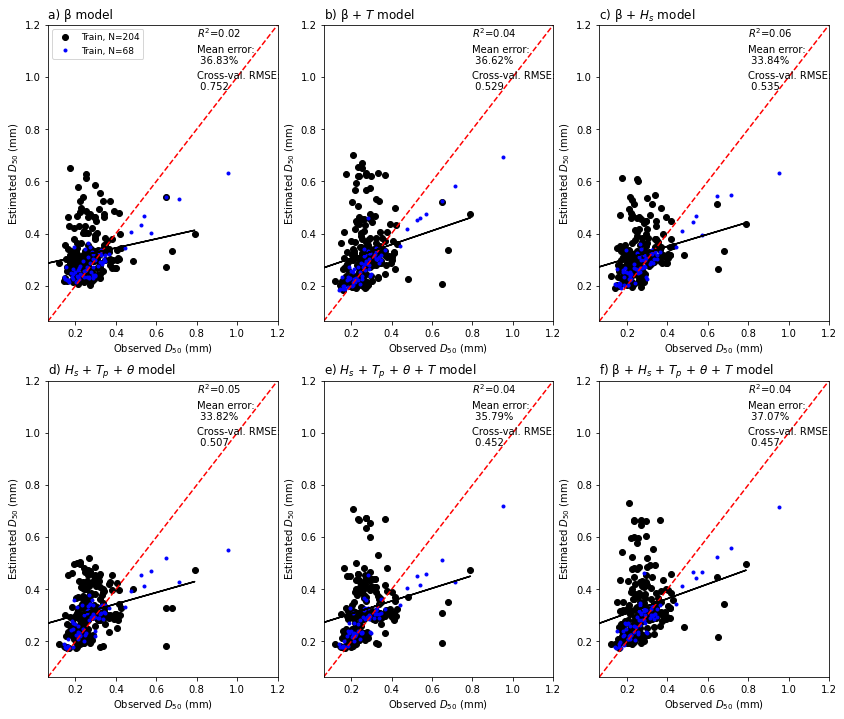

In [2307]:
plt.figure(figsize=(14,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(231)
ds_est = model7.predict(X_test7)
plt.plot(y_test7, ds_est, 'ko', label='Train, N={}'.format(int(len(tmpOz)*(test_size))))

# code = tmp['code'][indices_test7]
# plt.plot(y_test7[code==0], ds_est[code==0], 'ko', label='Test, E. Aus., N={}'.format(int(len(tmp)*(test_size)/2)))
# plt.plot(y_test7[code==1], ds_est[code==1], 'rs',alpha=0.5, label='Test, S.E. U.S., N={}'.format(int(len(tmp)*(test_size)/2)))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'b.', label='Train, N={}'.format(int(len(tmpOz)*(1-test_size))))

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) β model", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')

pe = prc_err(y_test7, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model7out['rmse_mean_xval'])[:5]))

plt.legend(fontsize=9)

plt.subplot(232)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')

# code = tmp['code'][indices_test2]
# plt.plot(y_test2[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
# plt.plot(y_test2[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("b) β + $T$ model", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')

pe = prc_err(y_test2, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model2out['rmse_mean_xval'])[:5]))

plt.subplot(233)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko')

# code = tmp['code'][indices_test6]
# plt.plot(y_test6[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
# plt.plot(y_test6[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"c) β + $H_s$ model", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:5]))
pe = prc_err(y_test6, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model6out['rmse_mean_xval'])[:5]))

plt.subplot(234)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')

# code = tmp['code'][indices_test3]
# plt.plot(y_test3[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
# plt.plot(y_test3[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"d) $H_s$ + $T_p$ + $\theta$ model", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:5]))
pe = prc_err(y_test3, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model3out['rmse_mean_xval'])[:5]))

plt.subplot(235)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')

# code = tmp['code'][indices_test4]
# plt.plot(y_test4[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
# plt.plot(y_test4[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'b.')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:5]))
pe = prc_err(y_test4, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model4out['rmse_mean_xval'])[:5]))

plt.subplot(236)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko')

# code = tmp['code'][indices_test1]
# plt.plot(y_test1[code==0], ds_est[code==0], 'ko', label='Test, Aus.')
# plt.plot(y_test1[code==1], ds_est[code==1], 'rs', alpha=0.5, label='Test, US. S.Atlantic')

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'b.', label='Train')

plt.xlim(0.063,1.2); plt.ylim(0.063,1.2)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) β + $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.8,1.15,r'$R^2$='+str(r2)[:4], color='k')

pe = prc_err(y_test1, ds_est)#.values
ind = np.where(~np.isinf(pe))[0]
pe = pe[ind]
plt.text(.8,1.05, 'Mean error:\n {}%'.format(str(np.mean(pe))[:5]))
plt.text(.8,.95, 'Cross-val. RMSE:\n {}'.format(str(combo_model1out['rmse_mean_xval'])[:5]))

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
# plt.legend()


plt.savefig('CGRASP_d50-6models_Oz-all.jpg', dpi=300, bbox_inches='tight')
# plt.close()

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation

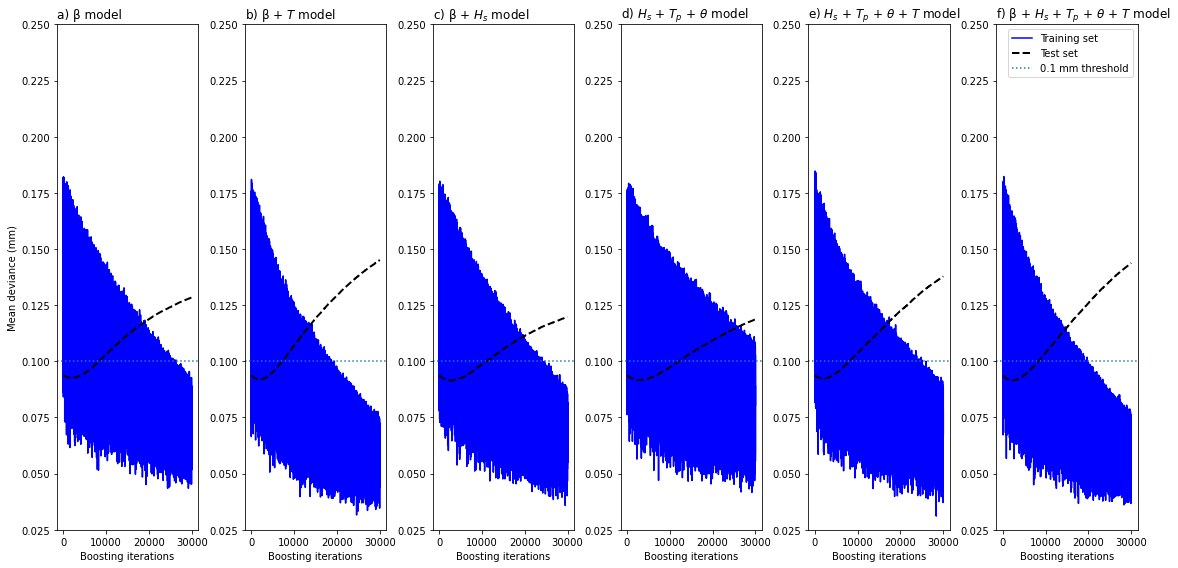

In [2308]:
fig=plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred7 in enumerate(model7.staged_predict(X_test7)):
    test_score[i] = model7.loss_(y_test7, y_pred7)
    
plt.subplot(1, 6, 1)
plt.title(r"a) β model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model7.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred2 in enumerate(model2.staged_predict(X_test2)):
    test_score[i] = model2.loss_(y_test2, y_pred2)
    
plt.subplot(1, 6, 2)
plt.title("b) β + $T$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model2.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred6 in enumerate(model6.staged_predict(X_test6)):
    test_score[i] = model6.loss_(y_test6, y_pred6)
    
plt.subplot(1, 6, 3)
plt.title(r"c) β + $H_s$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model6.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred3 in enumerate(model3.staged_predict(X_test3)):
    test_score[i] = model3.loss_(y_test3, y_pred3)
    
plt.subplot(1, 6, 4)
plt.title(r"d) $H_s$ + $T_p$ + $\theta$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model3.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred4 in enumerate(model4.staged_predict(X_test4)):
    test_score[i] = model4.loss_(y_test4, y_pred4)
    
plt.subplot(1, 6, 5)
plt.title(r"e) $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model4.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

####################################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred1 in enumerate(model1.staged_predict(X_test1)):
    test_score[i] = model1.loss_(y_test1, y_pred1)
    
plt.subplot(1, 6, 6)
plt.title(r"f) β + $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model1.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "k--", label="Test set", lw=2
)
plt.axhline(np.sqrt(0.01), linestyle=':',label='0.1 mm threshold')
plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Mean deviance (mm)")
plt.ylim(.025,.25)

fig.tight_layout()
# plt.show()
plt.savefig('CGRASP_d50-6models-training_Oz-all.jpg', dpi=300, bbox_inches='tight')

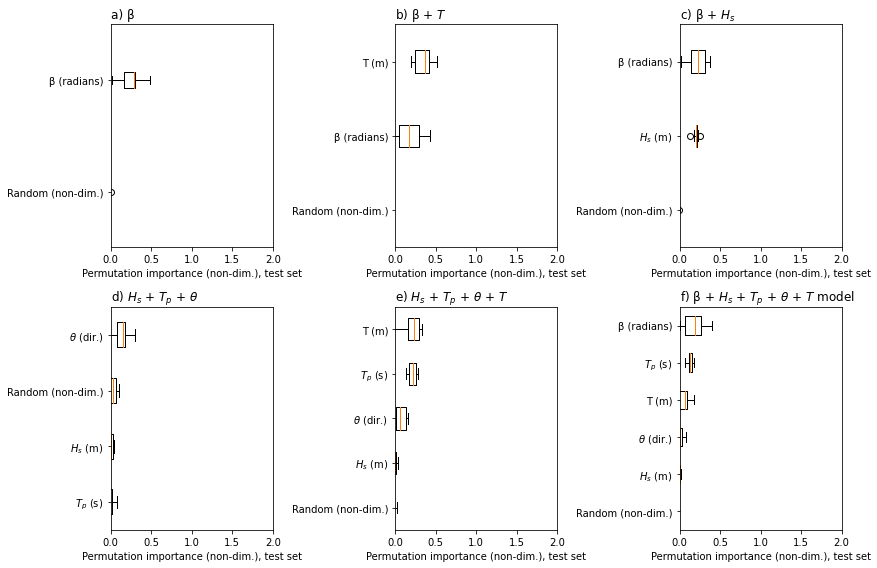

In [2309]:
fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
#############
plt.subplot(2,3, 1)
result = permutation_importance(
    model7, X_test7, y_test7, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(236)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names7)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"a) β ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 2)
result = permutation_importance(
    model2, X_test2, y_test2, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(232)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names2)[sorted_idx],
)

plt.xlim(0,2)
plt.title("b) β + $T$ ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 3)
result = permutation_importance(
    model6, X_test6, y_test6, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(235)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names6)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"c) β + $H_s$  ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 4)
result = permutation_importance(
    model3, X_test3, y_test3, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(233)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names3)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"d) $H_s$ + $T_p$ + $\theta$ ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

#############
plt.subplot(2,3, 5)
result = permutation_importance(
    model4, X_test4, y_test4, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(234)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names4)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"e) $H_s$ + $T_p$ + $\theta$ + $T$ ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

# fig.tight_layout()

#############
plt.subplot(2,3, 6)
result = permutation_importance(
    model1, X_test1, y_test1, n_repeats=10, random_state=2022, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(231)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names1)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"f) β + $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
fig.tight_layout()

plt.savefig('CGRASP_d50-6models-featimps_Oz-all.jpg', dpi=300, bbox_inches='tight')


In [2310]:
np.save('Aus_model1.npy', Aus_model1out, allow_pickle=True)
np.save('Aus_model2.npy', Aus_model2out, allow_pickle=True)
np.save('Aus_model3.npy', Aus_model3out, allow_pickle=True)
np.save('Aus_model4.npy', Aus_model4out, allow_pickle=True)
np.save('Aus_model6.npy', Aus_model6out, allow_pickle=True)
np.save('Aus_model7.npy', Aus_model7out, allow_pickle=True)


### Plots